In [1]:
#@title Find dataset statistical distance using previous classifiers

# Slight alteration over the above including classification error evaluation (the above here means previous code - see Colab page)
# Here, the classifiers is still reinitialised at each iteration, but the VAE is not
# The old classifiers are tasked with classifying the newly generated digits, and their loss and accuracy are recorded
# This (probably downward) trend in accuracy can then be used as an automatic metric for how the distributions are shifting
# The learned features of older classifiers are used here, instead of arbitrary statistical metrics, for measuring difference between distributions

# Some comments removed for readability. See above cell for more

# Note that the balanced version of EMNIST has 112800 samples

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import math

# Define hyperparameters # As of right now, these are broadly speaking the same parameters as used in the MNIST trial
batch_size = 128
latent_dim = 50 # the smallest layer in the VAE. Setting to 30 feels about right, and is slightly larger than MNIST. Attempted with 50?
vae_hidden_layers = [256, 128, 64] # numbers of neurons in fully connected layers
classifier_hidden_dim = 512 # hidden dimension in the classifier
learning_rate = 5e-4 # smaller than before. I had only ever used 1e-3. Hopefully this helps later training.
vae_num_epochs = 70 # higher slows collapse # set to 300 here rather than 200 in the earlier trials. More classes, so may need more space
classifier_num_epochs = 200 # Larger numbers required for EMNIST
num_iterations = 25  # Number of times to repeat the process
num_samples = 112800  # Number of samples to generate in each iteration # Note that original EMNIST (all 112800) are still used regardless of this value for the first iteration
num_images = 20 # This is for printing samples. Not actually relevant to the code logic
# the number of samples is presently set to 60000 for comparison with the MNIST work. Will be interesting to see how this winds up working

# Load original EMNIST dataset
dataset_mean = 0.1751
dataset_std = 0.3332
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((dataset_mean,), (dataset_std,)) # mean and variance. See later cells to see how these were calculated
    # normalisation accelerates convergence of the VAE, and possibly of the classifier. However, it means MSE as opposed to BCE must be used
])

original_dataset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform) # separate download each time

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_layers, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(hidden_layers[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_layers[-1], latent_dim)
        
        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_layers):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(hidden_layers[0], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the Classifier
# Classifier loss is given as cross entropy. Defined in the classifier train loop (train_classifier)
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# VAE loss function
def vae_loss_function(recon_x, x, mu, logvar): # recon_x is short for reconstructed
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction='sum') # MSE required. BCE can be used if normalisation is not introduced
    # BCE makes more theoretical sense, but seems irrelevant in practice
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # closed form for KLD between gaussians
    return MSE + KLD

# Train VAE
def train_vae(vae, optimizer, dataloader):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data) # reconstructed batch straight from vae.forward
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward() # fails when reparameterisation isn't implemented appropriately
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(dataloader.dataset) # necessary for stability if num_samples is not equal to 60,000

# Train Classifier
def train_classifier(classifier, optimizer, dataloader): # could pass the raw dataset to avoid dependencies?
    classifier.train()
    criterion = nn.CrossEntropyLoss()
    train_loss = 0
    correct = 0 # for later accuracy calculation. Entirely for evaluation
    for data, target in dataloader:
        optimizer.zero_grad()
        output = classifier(data.view(data.size(0), -1)) # turn to an array
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True) # unclear how slow argmax is as a step, but it is certainly easier than implementing a for loop here
        correct += pred.eq(target.view_as(pred)).sum().item()
    return train_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

# Function to generate new digits. Note that this is for training the next iteration of the models. The visualisation occurs elsewhere, and displays the first num_images of these generated samples
def generate_digits(vae, num_samples):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        samples = vae.decode(z)
    return samples

# Classify generated digits. Uses the previous iteration's classifier, bootstrapping future classifiers.
# Note that this could potentially be done by directly partitioning the latent space while samples are drawn
def classify_digits(classifier, digits):
    classifier.eval()
    with torch.no_grad():
        output = classifier(digits)
        labels = output.argmax(dim=1)
    return labels

def visualize_digits(digits, labels, iteration): # removed the original EMINST code and replaced it with MNIST work. Should work fine?
    num_digits = len(digits)
    num_rows = math.ceil(num_digits / 10) # required  to allow arbitrary numbers to be shown
    # Currently creates a single image out of all of them with 10 columns, and the digits stacked on top of one another
    num_cols = min(num_digits, 10)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2*num_rows))
    fig.suptitle(f'Generated Digits - Iteration {iteration}')

    balanced_dict = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 
                 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 
                 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}

    if num_rows == 1:
        axes = axes.reshape(1, -1) # avoid index errors

    for i in range(num_digits):
        row = i // 10
        col = i % 10
        ax = axes[row, col]
        image = digits[i].reshape(28, 28)
        rotated_image = torch.rot90(image, k=-1)
        flipped_image = torch.flip(rotated_image, dims=[1])
        ax.imshow(flipped_image.squeeze(), cmap='gray') # recreates original MNIST images as faithfully as possible. Perhaps a custom cmap would be better for historic accuracy?
        ax.set_title(f'Label: {balanced_dict[labels[i].item()]}') # NOTE: Printed images are not sorted by label in any way. This could be resolved in future?
        ax.axis('off')

    # Remove any unused subplots. Without this, there may be graphical glitches and poorly placed images
    for i in range(num_digits, num_rows * num_cols):
        row = i // 10
        col = i % 10
        fig.delaxes(axes[row, col])

    plt.tight_layout() # I might want this. It seems to place the title too low, such that it overlaps with the images themselves. Removing this fixes the title issue
    plt.show()

# New function to evaluate a classifier on a dataset
# GIven that this takes an arbitrary classifier and dataloader, this is used to test performance of historic classifiers on newly generated sets of images to test statistical distance
'''
def evaluate_classifier(classifier, dataloader):
    classifier.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): # very similar to evaluation done while training the classifier. See train_classifier
        for data, target in dataloader:
            output = classifier(data.view(data.size(0), -1))
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy
'''

# Update the evaluate_classifier function to ensure it uses batches
def evaluate_classifier(classifier, dataloader):
    classifier.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            data = data.view(-1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)
            output = classifier(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


# Main loop. Iterates over training of models and generating samples for new models
current_dataset = original_dataset
classifiers = []
loss_matrix = np.zeros((num_iterations, num_iterations)) # numpy shortcut for square zeros?
accuracy_matrix = np.zeros((num_iterations, num_iterations))

vae = VAE(784, vae_hidden_layers, latent_dim) # VAE is not reset after each iteration to save on computational time, requiring fewer generations to keep sensible results
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    # Create DataLoader
    dataloader = DataLoader(current_dataset, batch_size=batch_size, shuffle=True)

    # Initialize and train VAE
    #vae = VAE(784, vae_hidden_dim, latent_dim) # currently not being reinitialised
    vae_optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    for epoch in range(vae_num_epochs):
        loss = train_vae(vae, vae_optimizer, dataloader)
        if (epoch + 1) % 10 == 0:
            print(f'VAE Epoch {epoch+1}/{vae_num_epochs}, Loss: {loss:.4f}')

    # Initialize and train classifier
    classifier = Classifier(784, classifier_hidden_dim, 47) # EMNIST has 47 classes
    classifier_optimizer = optim.Adam(classifier.parameters(), lr=learning_rate) # does this need to be respecified?
    for epoch in range(classifier_num_epochs):
        loss, accuracy = train_classifier(classifier, classifier_optimizer, dataloader)
        if (epoch + 1) % 10 == 0:
            print(f'Classifier Epoch {epoch+1}/{classifier_num_epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    # Store the trained classifier in classifiers list. Used later for overall evaluation
    classifiers.append(classifier)

    # Generate new dataset
    generated_digits = generate_digits(vae, num_samples)
    generated_labels = classify_digits(classifier, generated_digits) # from prev classifier notably

    # Visualize some generated digits
    #visualize_digits(generated_digits[:num_images*num_cols], generated_labels[:num_images*num_cols], iteration + 1, num_rows=num_images, num_cols=num_cols) # num_images used to be set to 25. Produces no issues
    visualize_digits(generated_digits[:num_images], generated_labels[:num_images], iteration + 1) # num_images used to be set to 25. Produces no issues


    # Create new dataset for next iteration
    current_dataset = TensorDataset(generated_digits, generated_labels) # torch.utils.data.TensorDataset

    # Evaluate all previous classifiers on the new dataset, and writing to the loss and accuracy arrays
    new_dataloader = DataLoader(current_dataset, batch_size=batch_size, shuffle=False) # shuffle should be unnecessary as the sampling from the latent space is random
    for prev_iteration, prev_classifier in enumerate(classifiers):
        loss, accuracy = evaluate_classifier(prev_classifier, new_dataloader)
        loss_matrix[prev_iteration, iteration] = loss
        accuracy_matrix[prev_iteration, iteration] = accuracy

    # This line can be used to save the current dataset for later analysis. Requires drive loading
    #torch.save(current_dataset, f'generated_dataset_iteration_{iteration + 1}.pt')

# Save matrices for further analysis
#np.save('loss_matrix_EMNIST.npy', loss_matrix)
#np.save('accuracy_matrix_EMNIST.npy', accuracy_matrix)

Iteration 1/25
VAE Epoch 10/70, Loss: 170.2199


KeyboardInterrupt: 

Iteration 1/25
VAE Epoch 10/100, Loss: 170.1768
VAE Epoch 20/100, Loss: 154.9970
VAE Epoch 30/100, Loss: 147.8487
VAE Epoch 40/100, Loss: 143.6766
VAE Epoch 50/100, Loss: 140.9099
VAE Epoch 60/100, Loss: 138.9515
VAE Epoch 70/100, Loss: 137.3549
VAE Epoch 80/100, Loss: 136.0789
VAE Epoch 90/100, Loss: 134.9305
VAE Epoch 100/100, Loss: 134.0115
Classifier Epoch 10/50, Loss: 0.0017, Accuracy: 0.9119
Classifier Epoch 20/50, Loss: 0.0010, Accuracy: 0.9430
Classifier Epoch 30/50, Loss: 0.0007, Accuracy: 0.9621
Classifier Epoch 40/50, Loss: 0.0005, Accuracy: 0.9726
Classifier Epoch 50/50, Loss: 0.0004, Accuracy: 0.9788


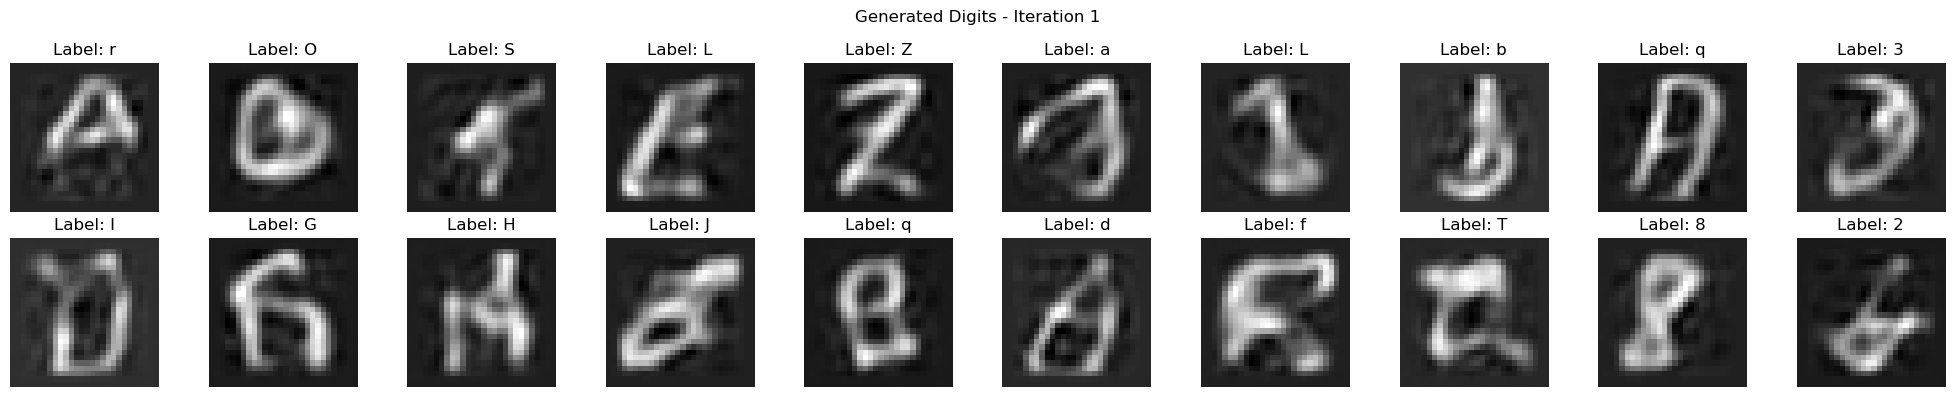

Iteration 2/25
VAE Epoch 10/100, Loss: 59.8277
VAE Epoch 20/100, Loss: 59.3150
VAE Epoch 30/100, Loss: 59.0792
VAE Epoch 40/100, Loss: 58.9242
VAE Epoch 50/100, Loss: 58.8014
VAE Epoch 60/100, Loss: 58.6625
VAE Epoch 70/100, Loss: 58.5790
VAE Epoch 80/100, Loss: 58.5281
VAE Epoch 90/100, Loss: 58.4997
VAE Epoch 100/100, Loss: 58.4521
Classifier Epoch 10/50, Loss: 0.0089, Accuracy: 0.6270
Classifier Epoch 20/50, Loss: 0.0059, Accuracy: 0.7414
Classifier Epoch 30/50, Loss: 0.0038, Accuracy: 0.8325
Classifier Epoch 40/50, Loss: 0.0024, Accuracy: 0.8922
Classifier Epoch 50/50, Loss: 0.0017, Accuracy: 0.9232


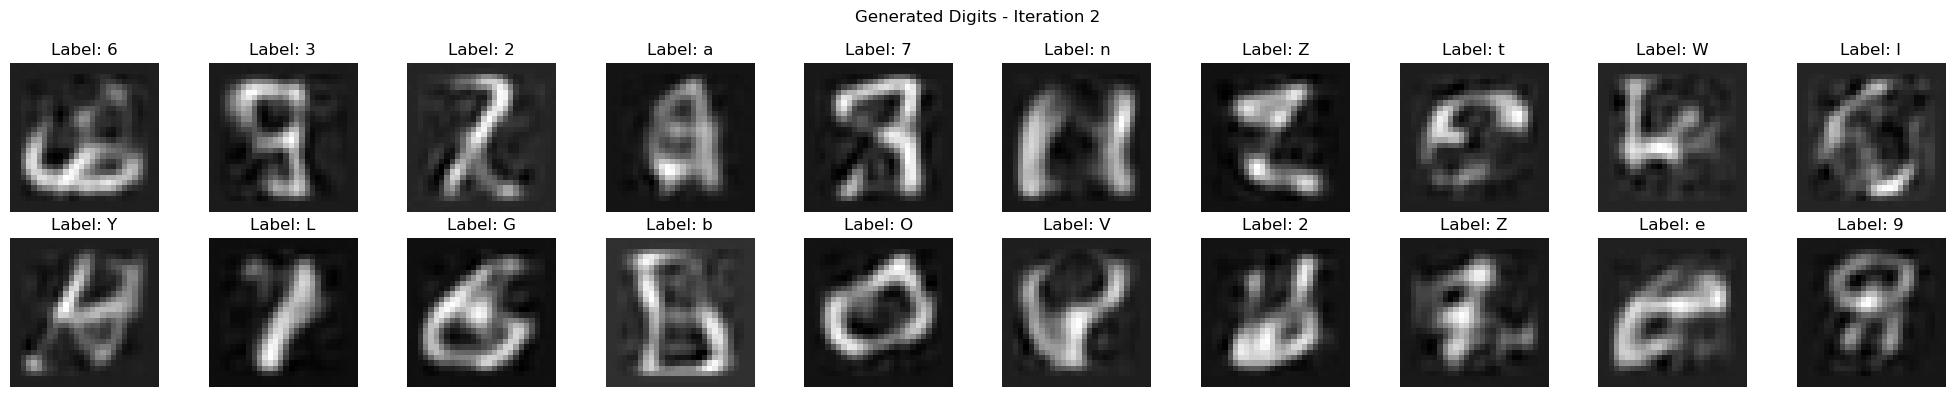

Iteration 3/25
VAE Epoch 10/100, Loss: 55.6739
VAE Epoch 20/100, Loss: 55.5735
VAE Epoch 30/100, Loss: 55.5488
VAE Epoch 40/100, Loss: 55.4736
VAE Epoch 50/100, Loss: 55.4709
VAE Epoch 60/100, Loss: 55.4378
VAE Epoch 70/100, Loss: 55.4288
VAE Epoch 80/100, Loss: 55.4329
VAE Epoch 90/100, Loss: 55.4068
VAE Epoch 100/100, Loss: 55.4158
Classifier Epoch 10/50, Loss: 0.0088, Accuracy: 0.6253
Classifier Epoch 20/50, Loss: 0.0058, Accuracy: 0.7459
Classifier Epoch 30/50, Loss: 0.0036, Accuracy: 0.8385
Classifier Epoch 40/50, Loss: 0.0022, Accuracy: 0.8973
Classifier Epoch 50/50, Loss: 0.0016, Accuracy: 0.9263


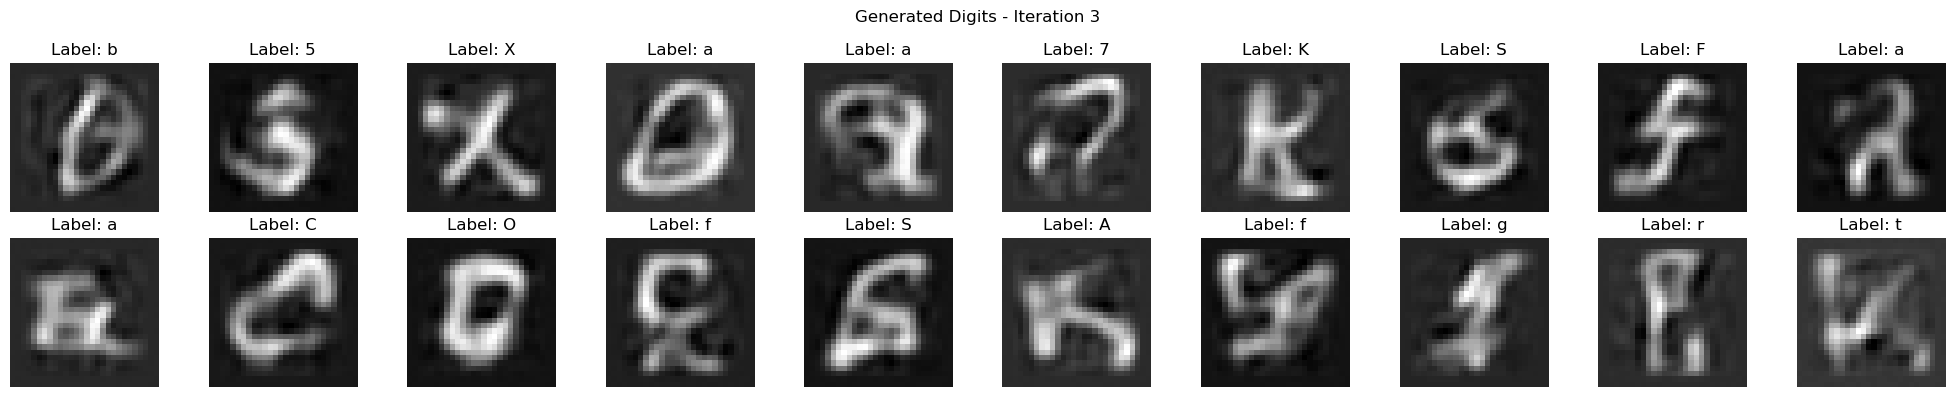

Iteration 4/25
VAE Epoch 10/100, Loss: 53.5658
VAE Epoch 20/100, Loss: 53.5748
VAE Epoch 30/100, Loss: 53.5740
VAE Epoch 40/100, Loss: 53.5122
VAE Epoch 50/100, Loss: 53.5016
VAE Epoch 60/100, Loss: 53.5353
VAE Epoch 70/100, Loss: 53.4755
VAE Epoch 80/100, Loss: 53.4616
VAE Epoch 90/100, Loss: 53.4698
VAE Epoch 100/100, Loss: 53.4694
Classifier Epoch 10/50, Loss: 0.0087, Accuracy: 0.6287
Classifier Epoch 20/50, Loss: 0.0059, Accuracy: 0.7402
Classifier Epoch 30/50, Loss: 0.0038, Accuracy: 0.8298
Classifier Epoch 40/50, Loss: 0.0025, Accuracy: 0.8867
Classifier Epoch 50/50, Loss: 0.0017, Accuracy: 0.9203


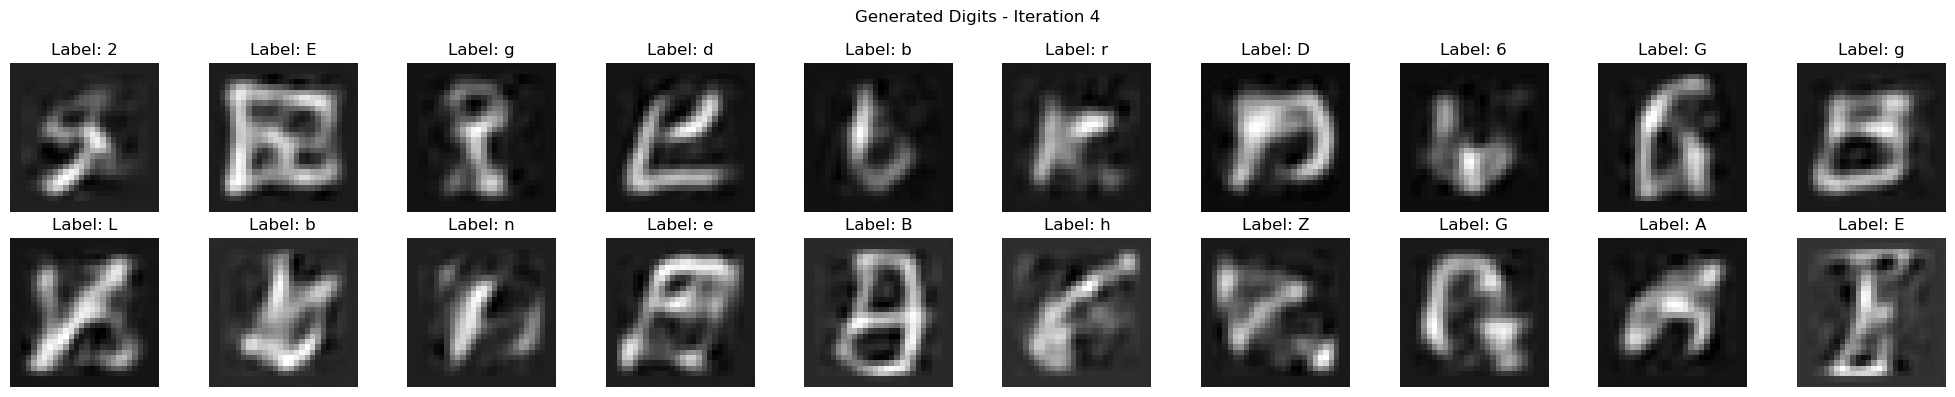

Iteration 5/25
VAE Epoch 10/100, Loss: 51.8660
VAE Epoch 20/100, Loss: 51.8943
VAE Epoch 30/100, Loss: 51.8507
VAE Epoch 40/100, Loss: 51.8374
VAE Epoch 50/100, Loss: 51.8136
VAE Epoch 60/100, Loss: 51.8098
VAE Epoch 70/100, Loss: 51.8411
VAE Epoch 80/100, Loss: 51.8130
VAE Epoch 90/100, Loss: 51.7818
VAE Epoch 100/100, Loss: 51.8036
Classifier Epoch 10/50, Loss: 0.0087, Accuracy: 0.6286
Classifier Epoch 20/50, Loss: 0.0062, Accuracy: 0.7287
Classifier Epoch 30/50, Loss: 0.0043, Accuracy: 0.8054
Classifier Epoch 40/50, Loss: 0.0029, Accuracy: 0.8661
Classifier Epoch 50/50, Loss: 0.0020, Accuracy: 0.9057


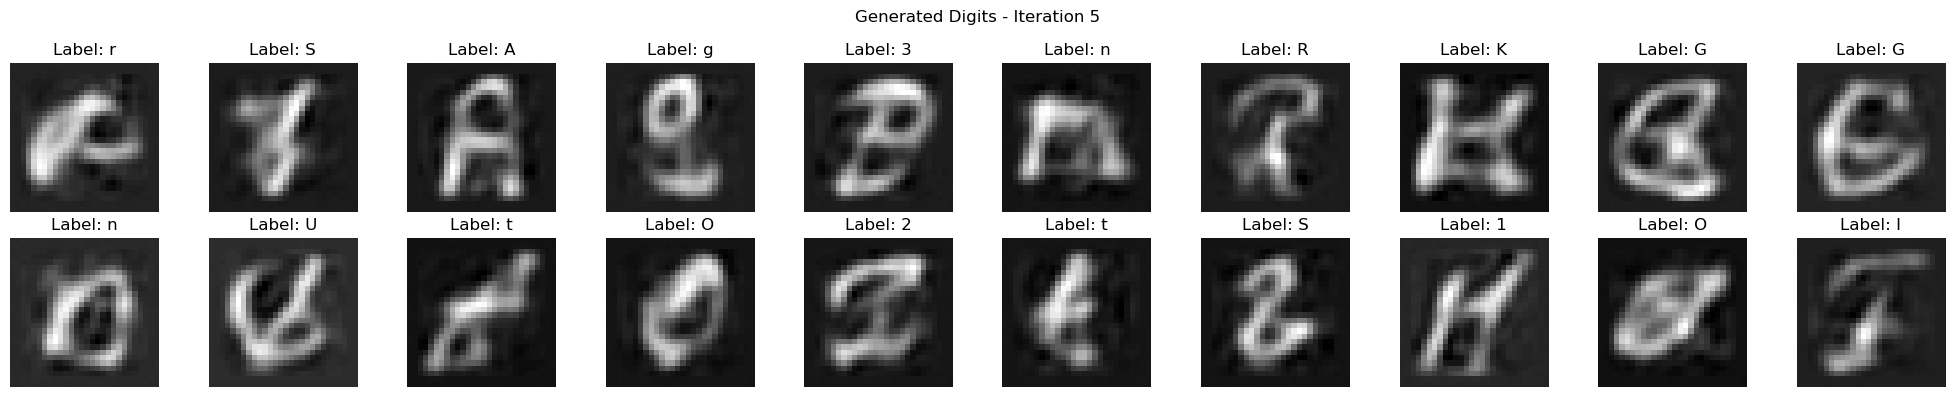

Iteration 6/25
VAE Epoch 10/100, Loss: 50.3642
VAE Epoch 20/100, Loss: 50.3158
VAE Epoch 30/100, Loss: 50.3192
VAE Epoch 40/100, Loss: 50.3399
VAE Epoch 50/100, Loss: 50.3101
VAE Epoch 60/100, Loss: 50.2896
VAE Epoch 70/100, Loss: 50.3197
VAE Epoch 80/100, Loss: 50.3449
VAE Epoch 90/100, Loss: 50.3130
VAE Epoch 100/100, Loss: 50.2750
Classifier Epoch 10/50, Loss: 0.0079, Accuracy: 0.6548
Classifier Epoch 20/50, Loss: 0.0053, Accuracy: 0.7636
Classifier Epoch 30/50, Loss: 0.0033, Accuracy: 0.8479
Classifier Epoch 40/50, Loss: 0.0021, Accuracy: 0.9036
Classifier Epoch 50/50, Loss: 0.0015, Accuracy: 0.9300


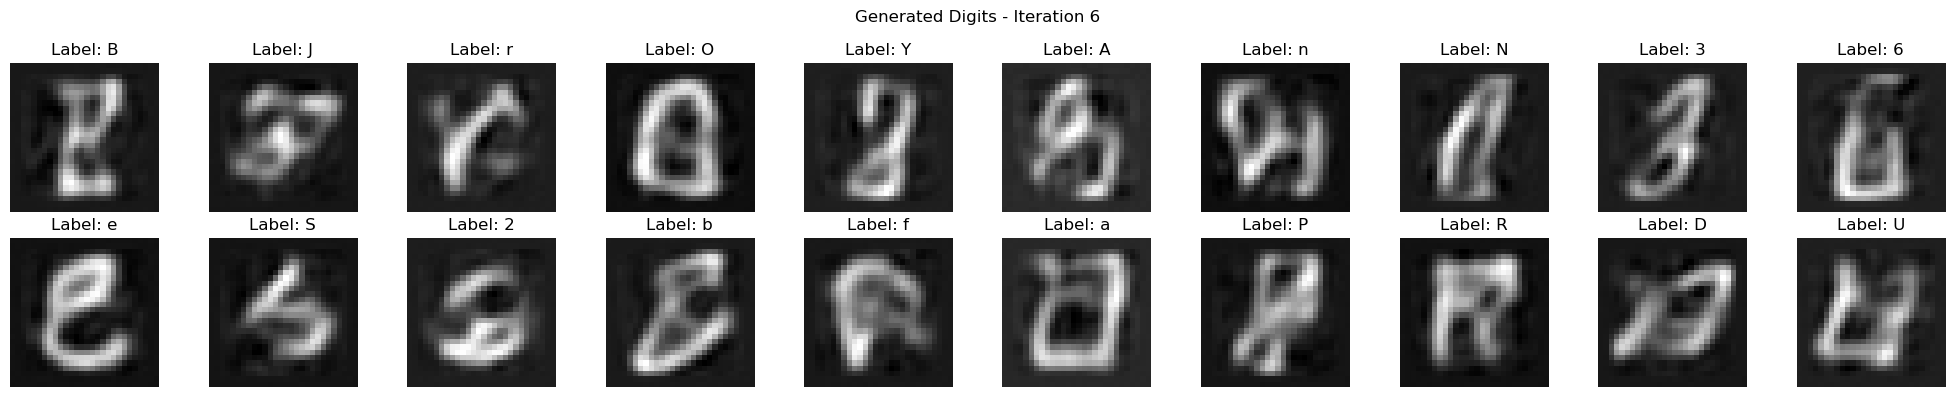

Iteration 7/25
VAE Epoch 10/100, Loss: 48.8042
VAE Epoch 20/100, Loss: 48.7907
VAE Epoch 30/100, Loss: 48.7833
VAE Epoch 40/100, Loss: 48.7446
VAE Epoch 50/100, Loss: 48.7640
VAE Epoch 60/100, Loss: 48.7682
VAE Epoch 70/100, Loss: 48.7637
VAE Epoch 80/100, Loss: 48.7765
VAE Epoch 90/100, Loss: 48.7784
VAE Epoch 100/100, Loss: 48.7580
Classifier Epoch 10/50, Loss: 0.0078, Accuracy: 0.6600
Classifier Epoch 20/50, Loss: 0.0056, Accuracy: 0.7509
Classifier Epoch 30/50, Loss: 0.0039, Accuracy: 0.8215
Classifier Epoch 40/50, Loss: 0.0027, Accuracy: 0.8765
Classifier Epoch 50/50, Loss: 0.0019, Accuracy: 0.9100


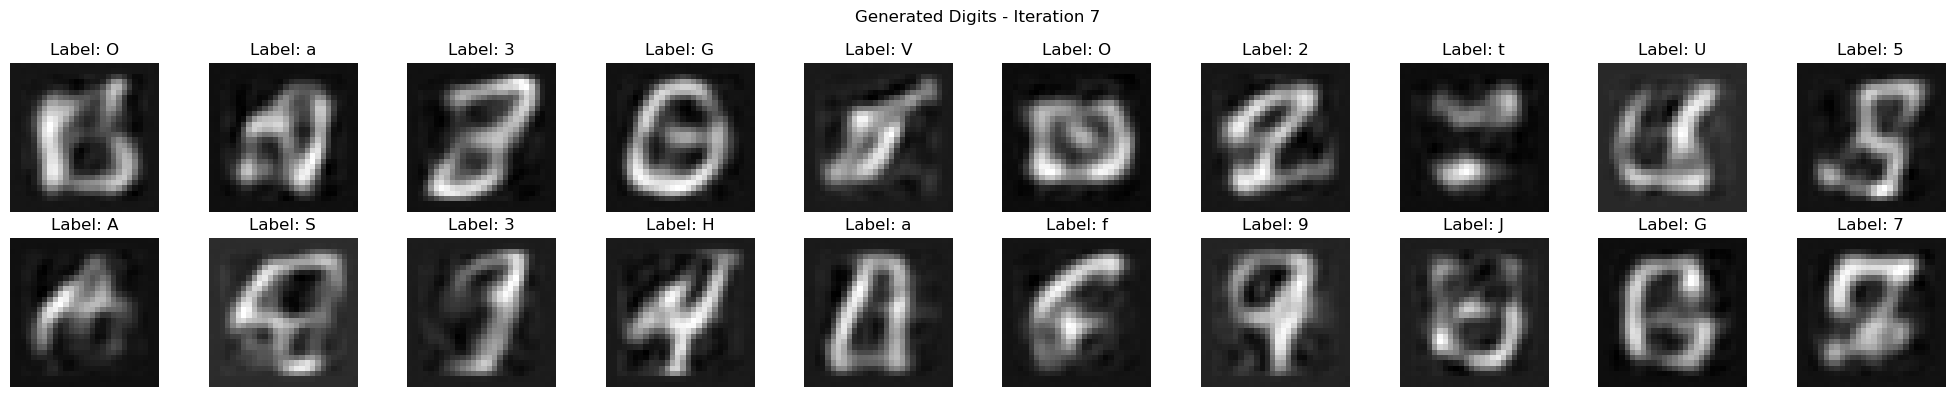

Iteration 8/25
VAE Epoch 10/100, Loss: 47.1988
VAE Epoch 20/100, Loss: 47.1505
VAE Epoch 30/100, Loss: 47.1587
VAE Epoch 40/100, Loss: 47.1765
VAE Epoch 50/100, Loss: 47.1739
VAE Epoch 60/100, Loss: 47.1589
VAE Epoch 70/100, Loss: 47.1489
VAE Epoch 80/100, Loss: 47.1474
VAE Epoch 90/100, Loss: 47.1048
VAE Epoch 100/100, Loss: 47.1252
Classifier Epoch 10/50, Loss: 0.0069, Accuracy: 0.6940
Classifier Epoch 20/50, Loss: 0.0045, Accuracy: 0.7979
Classifier Epoch 30/50, Loss: 0.0027, Accuracy: 0.8742
Classifier Epoch 40/50, Loss: 0.0017, Accuracy: 0.9210
Classifier Epoch 50/50, Loss: 0.0013, Accuracy: 0.9401


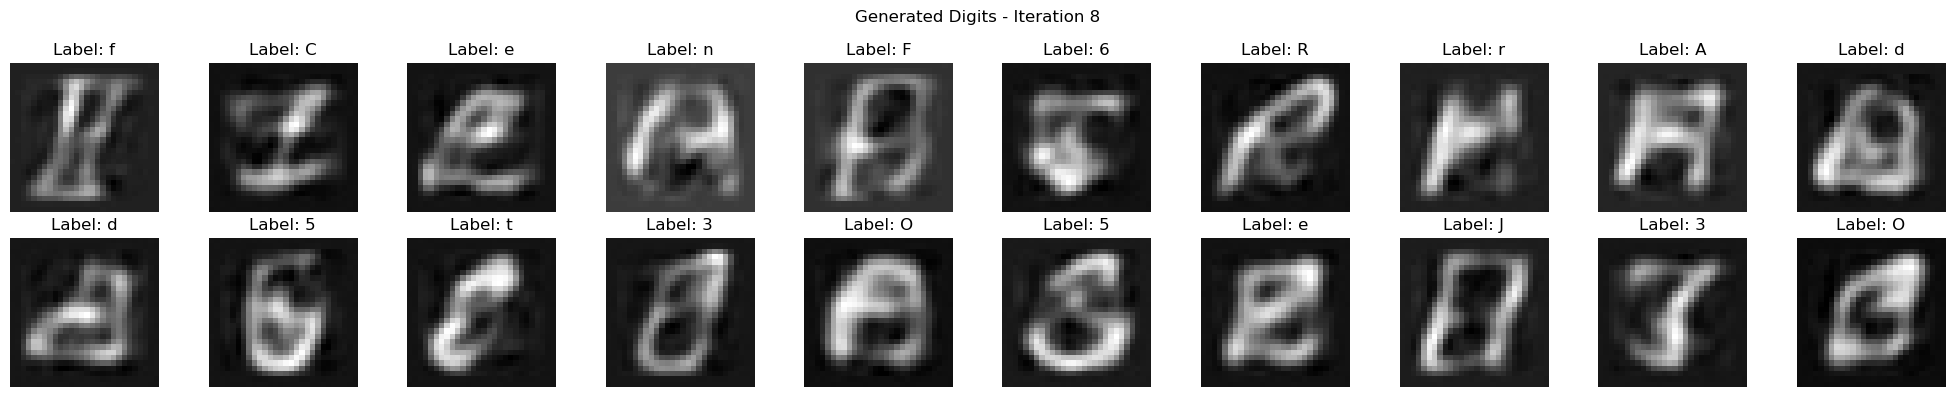

Iteration 9/25
VAE Epoch 10/100, Loss: 45.4948
VAE Epoch 20/100, Loss: 45.4652
VAE Epoch 30/100, Loss: 45.4593
VAE Epoch 40/100, Loss: 45.4493
VAE Epoch 50/100, Loss: 45.4526
VAE Epoch 60/100, Loss: 45.4386
VAE Epoch 70/100, Loss: 45.4436
VAE Epoch 80/100, Loss: 45.4430
VAE Epoch 90/100, Loss: 45.4773
VAE Epoch 100/100, Loss: 45.4534
Classifier Epoch 10/50, Loss: 0.0068, Accuracy: 0.6962
Classifier Epoch 20/50, Loss: 0.0047, Accuracy: 0.7877
Classifier Epoch 30/50, Loss: 0.0031, Accuracy: 0.8562
Classifier Epoch 40/50, Loss: 0.0020, Accuracy: 0.9043
Classifier Epoch 50/50, Loss: 0.0014, Accuracy: 0.9333


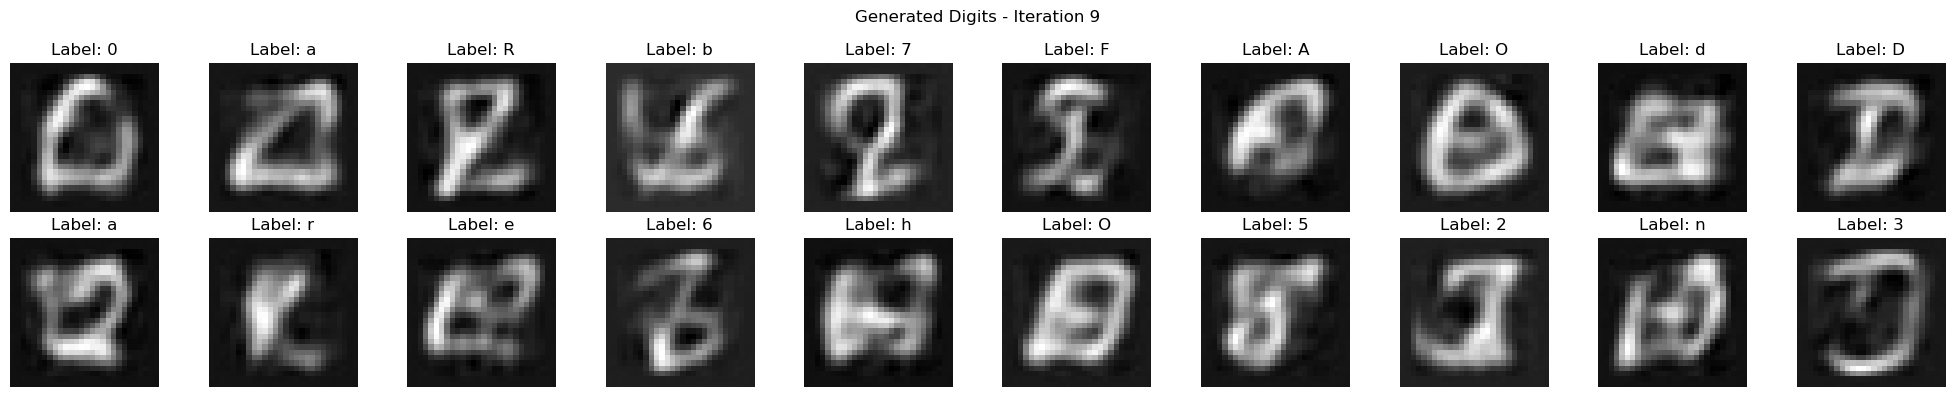

Iteration 10/25
VAE Epoch 10/100, Loss: 43.4543
VAE Epoch 20/100, Loss: 43.4251
VAE Epoch 30/100, Loss: 43.4178
VAE Epoch 40/100, Loss: 43.4332
VAE Epoch 50/100, Loss: 43.4352
VAE Epoch 60/100, Loss: 43.4228
VAE Epoch 70/100, Loss: 43.4227
VAE Epoch 80/100, Loss: 43.3994
VAE Epoch 90/100, Loss: 43.4326
VAE Epoch 100/100, Loss: 43.4252
Classifier Epoch 10/50, Loss: 0.0064, Accuracy: 0.7137
Classifier Epoch 20/50, Loss: 0.0044, Accuracy: 0.7967
Classifier Epoch 30/50, Loss: 0.0029, Accuracy: 0.8631
Classifier Epoch 40/50, Loss: 0.0019, Accuracy: 0.9113
Classifier Epoch 50/50, Loss: 0.0013, Accuracy: 0.9372


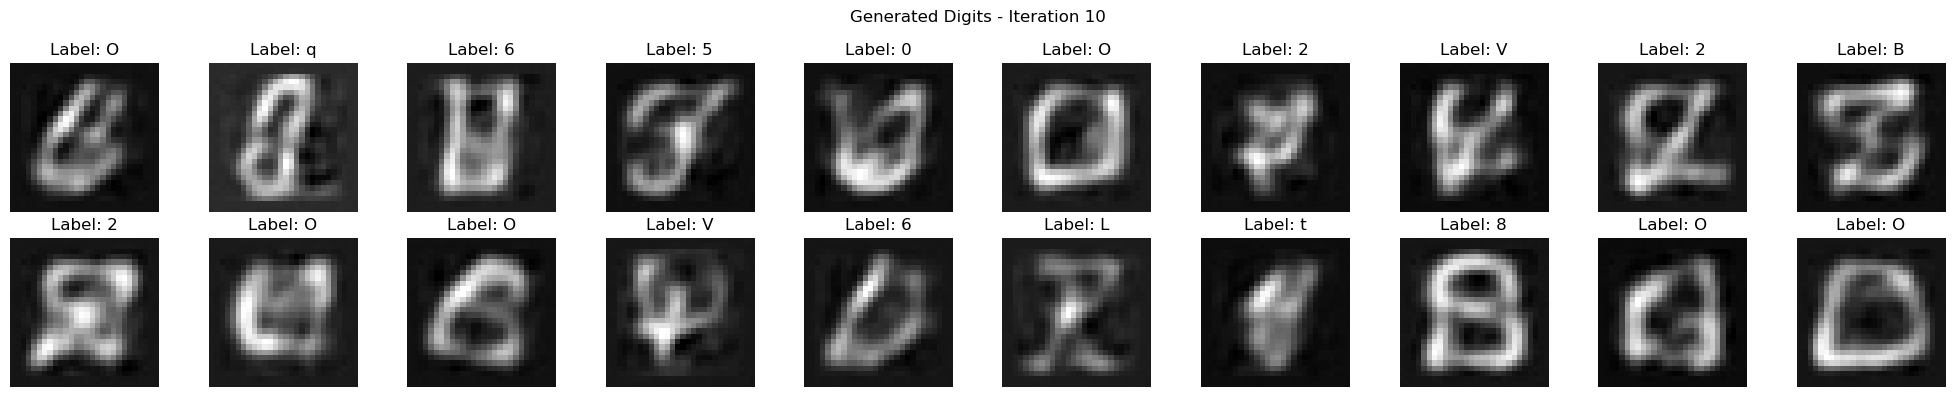

Iteration 11/25
VAE Epoch 10/100, Loss: 41.5239
VAE Epoch 20/100, Loss: 41.4961
VAE Epoch 30/100, Loss: 41.4860
VAE Epoch 40/100, Loss: 41.4787
VAE Epoch 50/100, Loss: 41.5112
VAE Epoch 60/100, Loss: 41.4882
VAE Epoch 70/100, Loss: 41.5060
VAE Epoch 80/100, Loss: 41.4630
VAE Epoch 90/100, Loss: 41.5236
VAE Epoch 100/100, Loss: 41.5023
Classifier Epoch 10/50, Loss: 0.0059, Accuracy: 0.7336
Classifier Epoch 20/50, Loss: 0.0038, Accuracy: 0.8232
Classifier Epoch 30/50, Loss: 0.0024, Accuracy: 0.8860
Classifier Epoch 40/50, Loss: 0.0015, Accuracy: 0.9269
Classifier Epoch 50/50, Loss: 0.0011, Accuracy: 0.9470


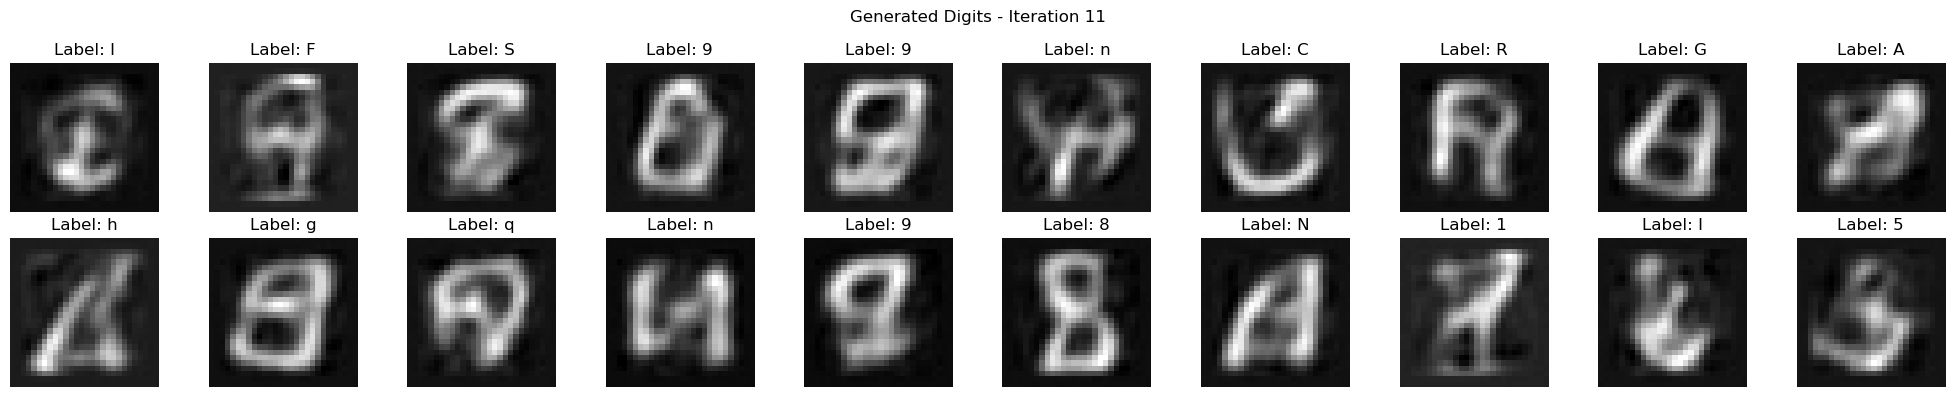

Iteration 12/25
VAE Epoch 10/100, Loss: 39.4672
VAE Epoch 20/100, Loss: 39.4609
VAE Epoch 30/100, Loss: 39.4491
VAE Epoch 40/100, Loss: 39.4398
VAE Epoch 50/100, Loss: 39.4483
VAE Epoch 60/100, Loss: 39.4405
VAE Epoch 70/100, Loss: 39.4415
VAE Epoch 80/100, Loss: 39.4257
VAE Epoch 90/100, Loss: 39.4332
VAE Epoch 100/100, Loss: 39.4340
Classifier Epoch 10/50, Loss: 0.0055, Accuracy: 0.7474
Classifier Epoch 20/50, Loss: 0.0036, Accuracy: 0.8296
Classifier Epoch 30/50, Loss: 0.0023, Accuracy: 0.8915
Classifier Epoch 40/50, Loss: 0.0015, Accuracy: 0.9295
Classifier Epoch 50/50, Loss: 0.0010, Accuracy: 0.9514


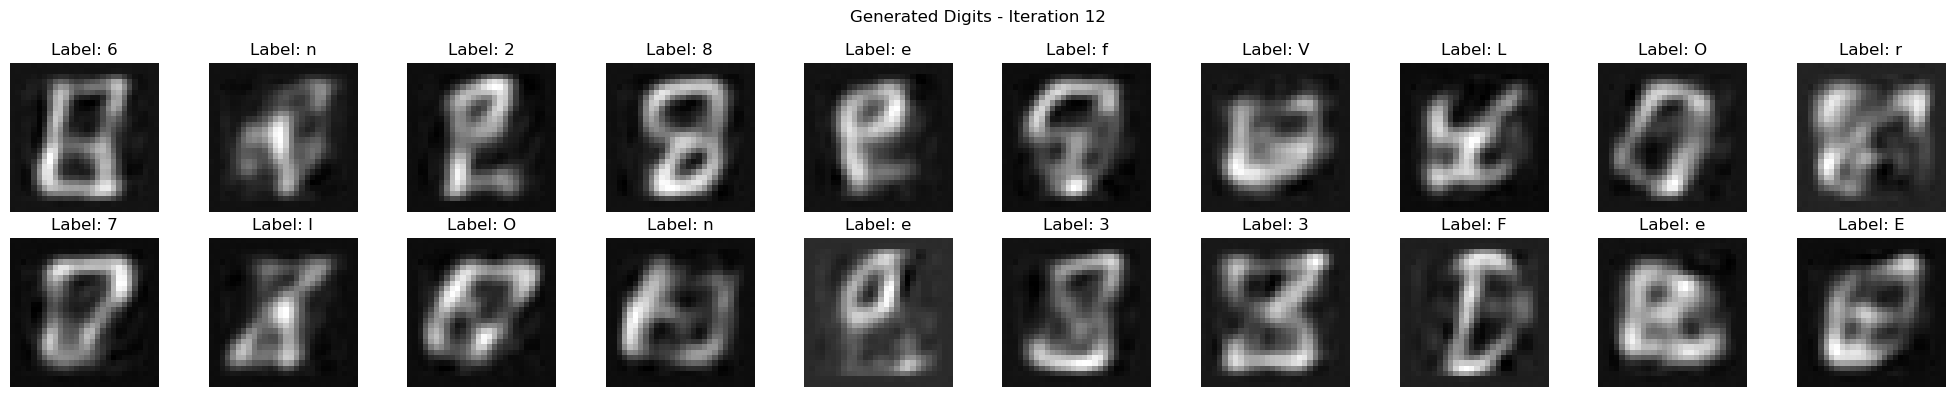

Iteration 13/25
VAE Epoch 10/100, Loss: 36.6105
VAE Epoch 20/100, Loss: 36.6041
VAE Epoch 30/100, Loss: 36.6284
VAE Epoch 40/100, Loss: 36.6263
VAE Epoch 50/100, Loss: 36.6039
VAE Epoch 60/100, Loss: 36.5953
VAE Epoch 70/100, Loss: 36.5814
VAE Epoch 80/100, Loss: 36.6054
VAE Epoch 90/100, Loss: 36.5902
VAE Epoch 100/100, Loss: 36.5966
Classifier Epoch 10/50, Loss: 0.0052, Accuracy: 0.7584
Classifier Epoch 20/50, Loss: 0.0036, Accuracy: 0.8320
Classifier Epoch 30/50, Loss: 0.0024, Accuracy: 0.8872
Classifier Epoch 40/50, Loss: 0.0016, Accuracy: 0.9253
Classifier Epoch 50/50, Loss: 0.0011, Accuracy: 0.9446


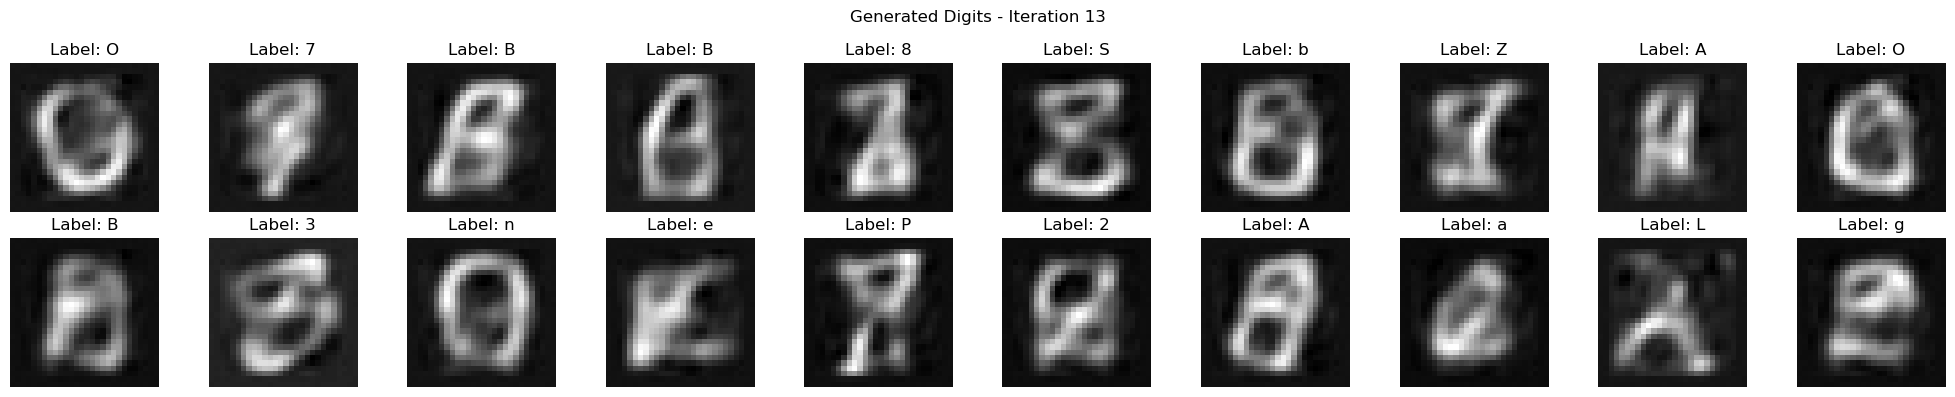

Iteration 14/25
VAE Epoch 10/100, Loss: 34.3603
VAE Epoch 20/100, Loss: 34.3791
VAE Epoch 30/100, Loss: 34.3910
VAE Epoch 40/100, Loss: 34.3787
VAE Epoch 50/100, Loss: 34.4101
VAE Epoch 60/100, Loss: 34.3757
VAE Epoch 70/100, Loss: 34.3923
VAE Epoch 80/100, Loss: 34.3596
VAE Epoch 90/100, Loss: 34.3858
VAE Epoch 100/100, Loss: 34.3808
Classifier Epoch 10/50, Loss: 0.0048, Accuracy: 0.7763
Classifier Epoch 20/50, Loss: 0.0032, Accuracy: 0.8498
Classifier Epoch 30/50, Loss: 0.0020, Accuracy: 0.9036
Classifier Epoch 40/50, Loss: 0.0013, Accuracy: 0.9386
Classifier Epoch 50/50, Loss: 0.0010, Accuracy: 0.9532


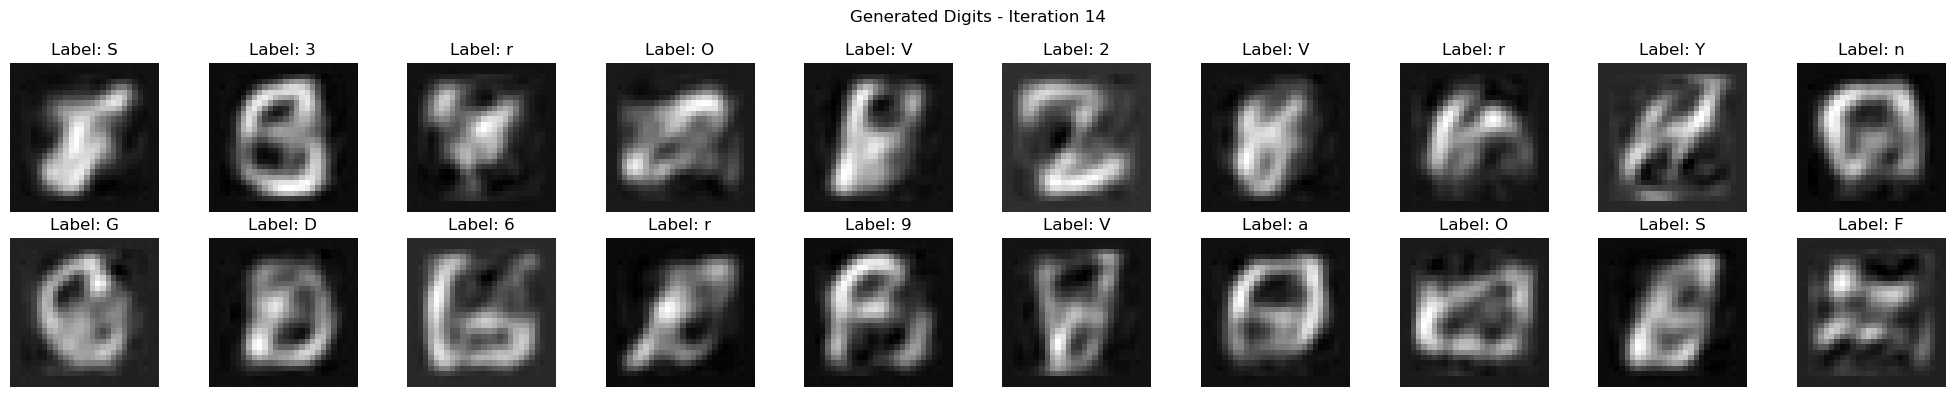

Iteration 15/25
VAE Epoch 10/100, Loss: 32.7211
VAE Epoch 20/100, Loss: 32.7079
VAE Epoch 30/100, Loss: 32.7193
VAE Epoch 40/100, Loss: 32.7296
VAE Epoch 50/100, Loss: 32.7134
VAE Epoch 60/100, Loss: 32.7151
VAE Epoch 70/100, Loss: 32.7095
VAE Epoch 80/100, Loss: 32.6981
VAE Epoch 90/100, Loss: 32.7152
VAE Epoch 100/100, Loss: 32.7084
Classifier Epoch 10/50, Loss: 0.0045, Accuracy: 0.7862
Classifier Epoch 20/50, Loss: 0.0029, Accuracy: 0.8609
Classifier Epoch 30/50, Loss: 0.0018, Accuracy: 0.9124
Classifier Epoch 40/50, Loss: 0.0012, Accuracy: 0.9440
Classifier Epoch 50/50, Loss: 0.0008, Accuracy: 0.9599


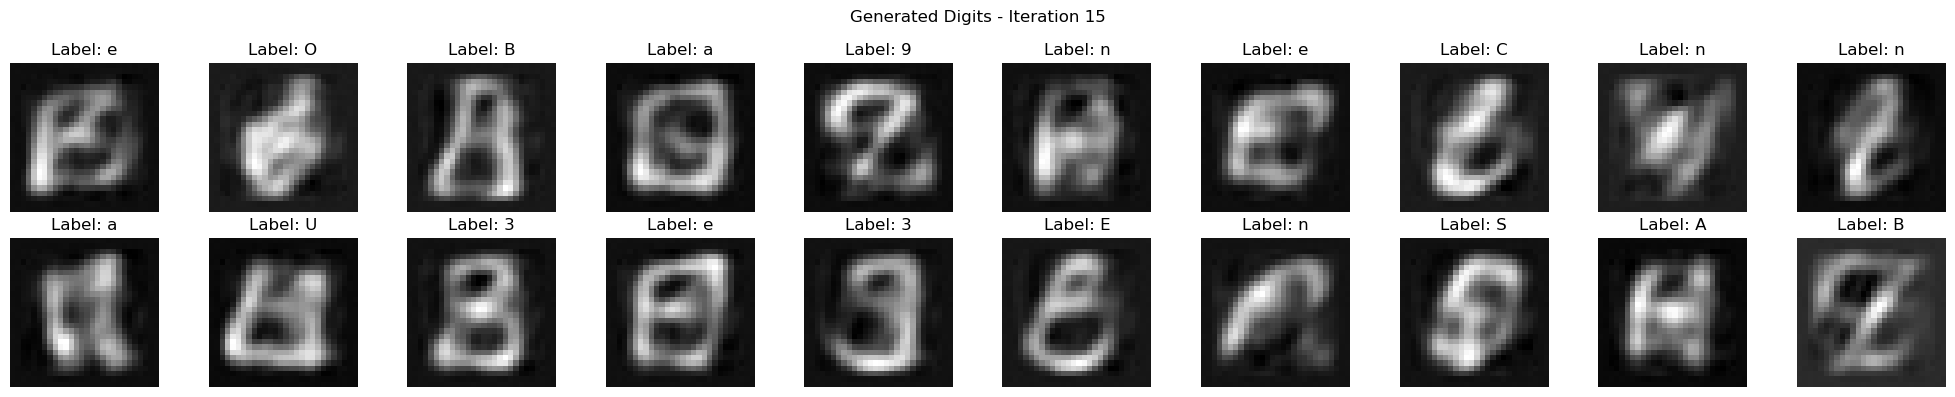

Iteration 16/25
VAE Epoch 10/100, Loss: 31.2802
VAE Epoch 20/100, Loss: 31.3021
VAE Epoch 30/100, Loss: 31.2880
VAE Epoch 40/100, Loss: 31.2963
VAE Epoch 50/100, Loss: 31.3182
VAE Epoch 60/100, Loss: 31.2881
VAE Epoch 70/100, Loss: 31.2910
VAE Epoch 80/100, Loss: 31.3126
VAE Epoch 90/100, Loss: 31.3034
VAE Epoch 100/100, Loss: 31.2884
Classifier Epoch 10/50, Loss: 0.0044, Accuracy: 0.7936
Classifier Epoch 20/50, Loss: 0.0029, Accuracy: 0.8627
Classifier Epoch 30/50, Loss: 0.0018, Accuracy: 0.9111
Classifier Epoch 40/50, Loss: 0.0012, Accuracy: 0.9408
Classifier Epoch 50/50, Loss: 0.0009, Accuracy: 0.9559


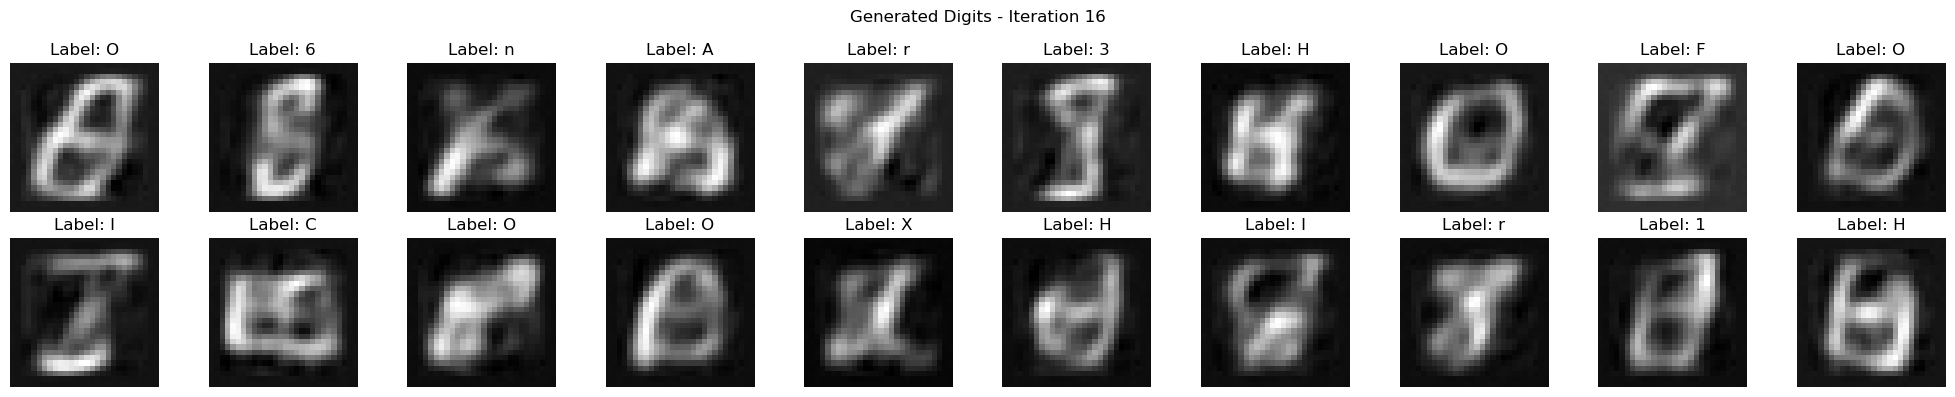

Iteration 17/25
VAE Epoch 10/100, Loss: 30.0059
VAE Epoch 20/100, Loss: 30.0174
VAE Epoch 30/100, Loss: 30.0163
VAE Epoch 40/100, Loss: 30.0071
VAE Epoch 50/100, Loss: 30.0029
VAE Epoch 60/100, Loss: 30.0151
VAE Epoch 70/100, Loss: 30.0184
VAE Epoch 80/100, Loss: 29.9939
VAE Epoch 90/100, Loss: 29.9938
VAE Epoch 100/100, Loss: 29.9933
Classifier Epoch 10/50, Loss: 0.0042, Accuracy: 0.7996
Classifier Epoch 20/50, Loss: 0.0028, Accuracy: 0.8651
Classifier Epoch 30/50, Loss: 0.0018, Accuracy: 0.9122
Classifier Epoch 40/50, Loss: 0.0012, Accuracy: 0.9419
Classifier Epoch 50/50, Loss: 0.0009, Accuracy: 0.9582


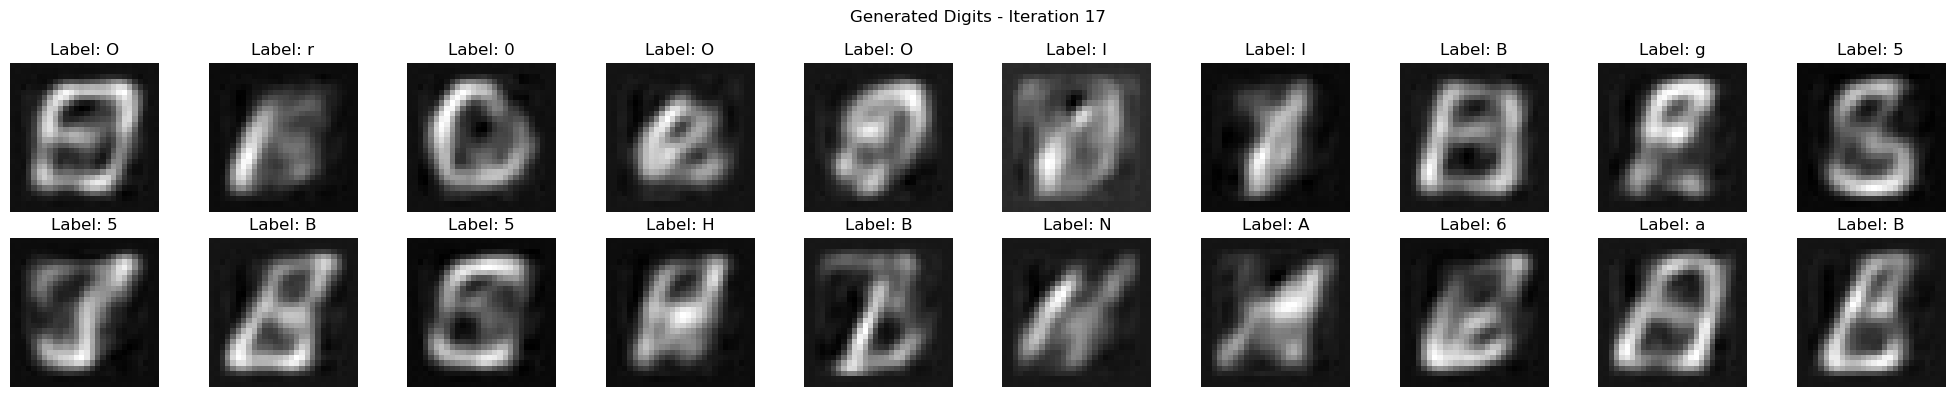

Iteration 18/25
VAE Epoch 10/100, Loss: 28.6615
VAE Epoch 20/100, Loss: 28.6435
VAE Epoch 30/100, Loss: 28.6450
VAE Epoch 40/100, Loss: 28.6426
VAE Epoch 50/100, Loss: 28.6317
VAE Epoch 60/100, Loss: 28.6427
VAE Epoch 70/100, Loss: 28.6199
VAE Epoch 80/100, Loss: 28.6426
VAE Epoch 90/100, Loss: 28.6463
VAE Epoch 100/100, Loss: 28.6324
Classifier Epoch 10/50, Loss: 0.0041, Accuracy: 0.8050
Classifier Epoch 20/50, Loss: 0.0028, Accuracy: 0.8659
Classifier Epoch 30/50, Loss: 0.0019, Accuracy: 0.9073
Classifier Epoch 40/50, Loss: 0.0013, Accuracy: 0.9355
Classifier Epoch 50/50, Loss: 0.0010, Accuracy: 0.9524


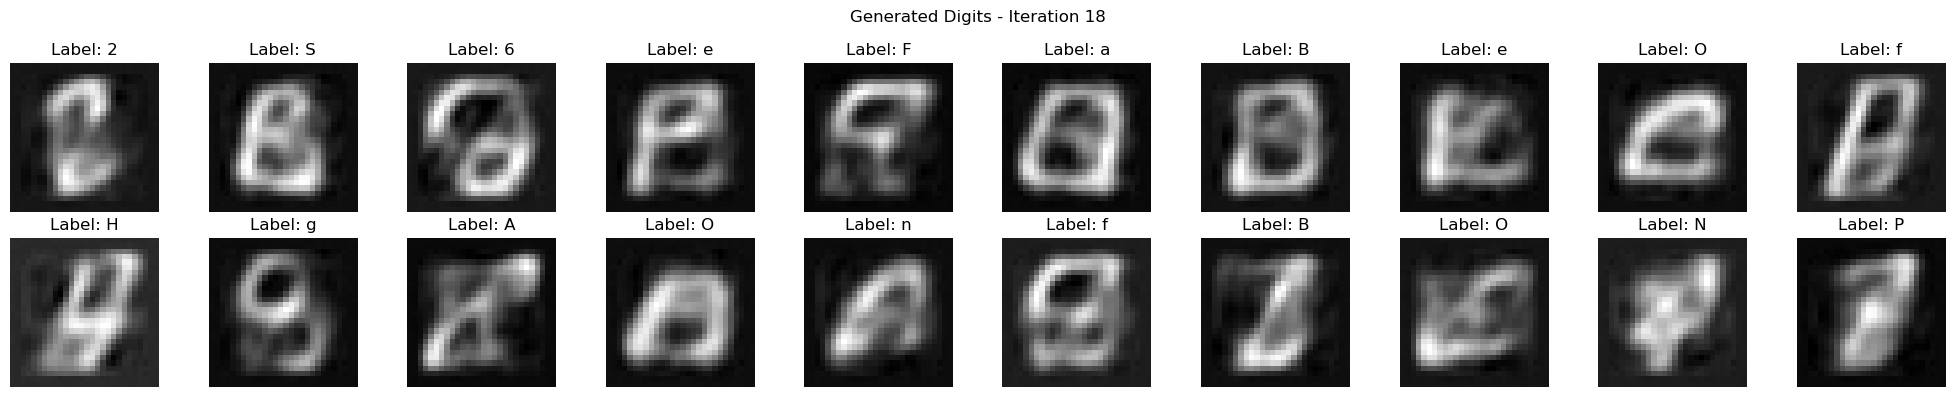

Iteration 19/25
VAE Epoch 10/100, Loss: 27.5787
VAE Epoch 20/100, Loss: 27.5823
VAE Epoch 30/100, Loss: 27.5825
VAE Epoch 40/100, Loss: 27.5767
VAE Epoch 50/100, Loss: 27.5578
VAE Epoch 60/100, Loss: 27.5628
VAE Epoch 70/100, Loss: 27.5771
VAE Epoch 80/100, Loss: 27.5852
VAE Epoch 90/100, Loss: 27.5680
VAE Epoch 100/100, Loss: 27.5778
Classifier Epoch 10/50, Loss: 0.0037, Accuracy: 0.8225
Classifier Epoch 20/50, Loss: 0.0025, Accuracy: 0.8788
Classifier Epoch 30/50, Loss: 0.0016, Accuracy: 0.9195
Classifier Epoch 40/50, Loss: 0.0011, Accuracy: 0.9468
Classifier Epoch 50/50, Loss: 0.0009, Accuracy: 0.9593


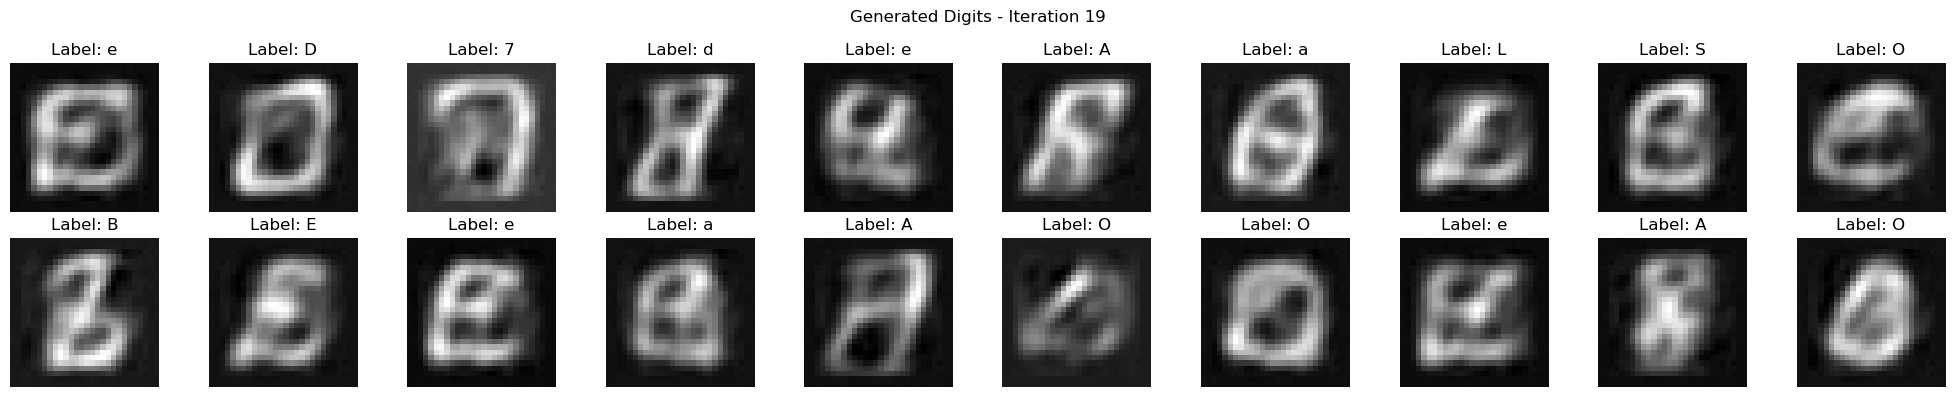

Iteration 20/25
VAE Epoch 10/100, Loss: 26.1784
VAE Epoch 20/100, Loss: 26.1798
VAE Epoch 30/100, Loss: 26.1555
VAE Epoch 40/100, Loss: 26.1690
VAE Epoch 50/100, Loss: 26.1706
VAE Epoch 60/100, Loss: 26.1676
VAE Epoch 70/100, Loss: 26.1611
VAE Epoch 80/100, Loss: 26.1677
VAE Epoch 90/100, Loss: 26.1604
VAE Epoch 100/100, Loss: 26.1849
Classifier Epoch 10/50, Loss: 0.0036, Accuracy: 0.8272
Classifier Epoch 20/50, Loss: 0.0024, Accuracy: 0.8836
Classifier Epoch 30/50, Loss: 0.0016, Accuracy: 0.9234
Classifier Epoch 40/50, Loss: 0.0011, Accuracy: 0.9457
Classifier Epoch 50/50, Loss: 0.0008, Accuracy: 0.9630


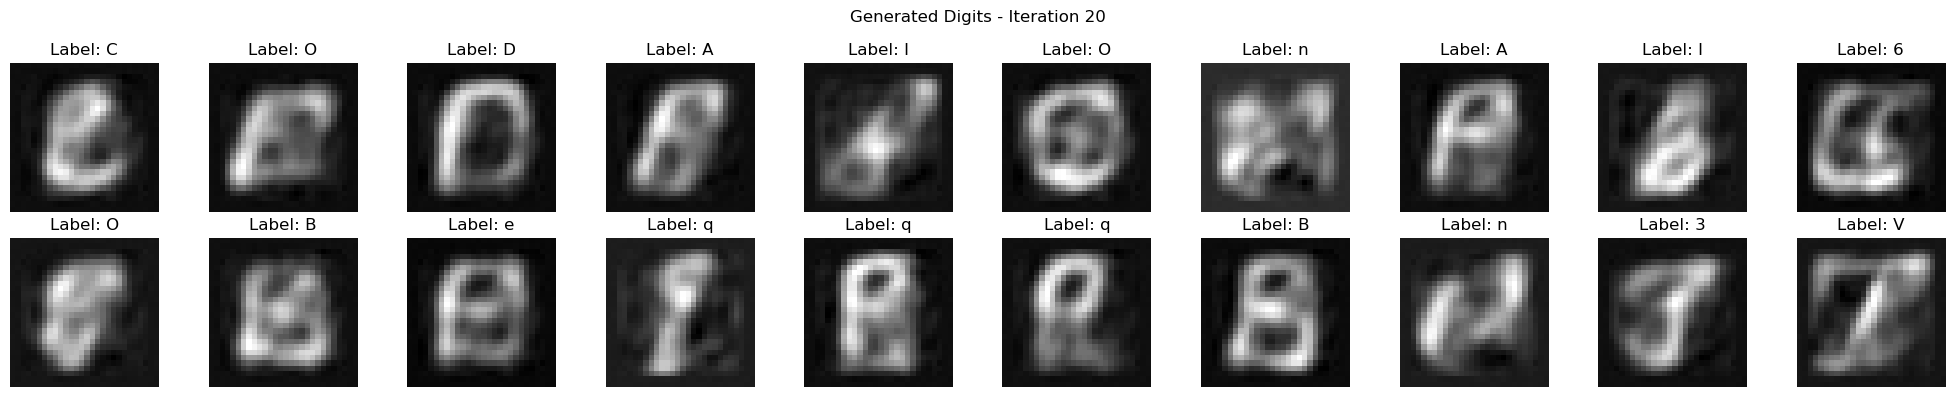

Iteration 21/25
VAE Epoch 10/100, Loss: 24.2194
VAE Epoch 20/100, Loss: 24.2137
VAE Epoch 30/100, Loss: 24.2262
VAE Epoch 40/100, Loss: 24.2239
VAE Epoch 50/100, Loss: 24.2164
VAE Epoch 60/100, Loss: 24.2125
VAE Epoch 70/100, Loss: 24.2254
VAE Epoch 80/100, Loss: 24.2180
VAE Epoch 90/100, Loss: 24.2171
VAE Epoch 100/100, Loss: 24.2114
Classifier Epoch 10/50, Loss: 0.0034, Accuracy: 0.8354
Classifier Epoch 20/50, Loss: 0.0023, Accuracy: 0.8884
Classifier Epoch 30/50, Loss: 0.0016, Accuracy: 0.9232
Classifier Epoch 40/50, Loss: 0.0011, Accuracy: 0.9451
Classifier Epoch 50/50, Loss: 0.0009, Accuracy: 0.9584


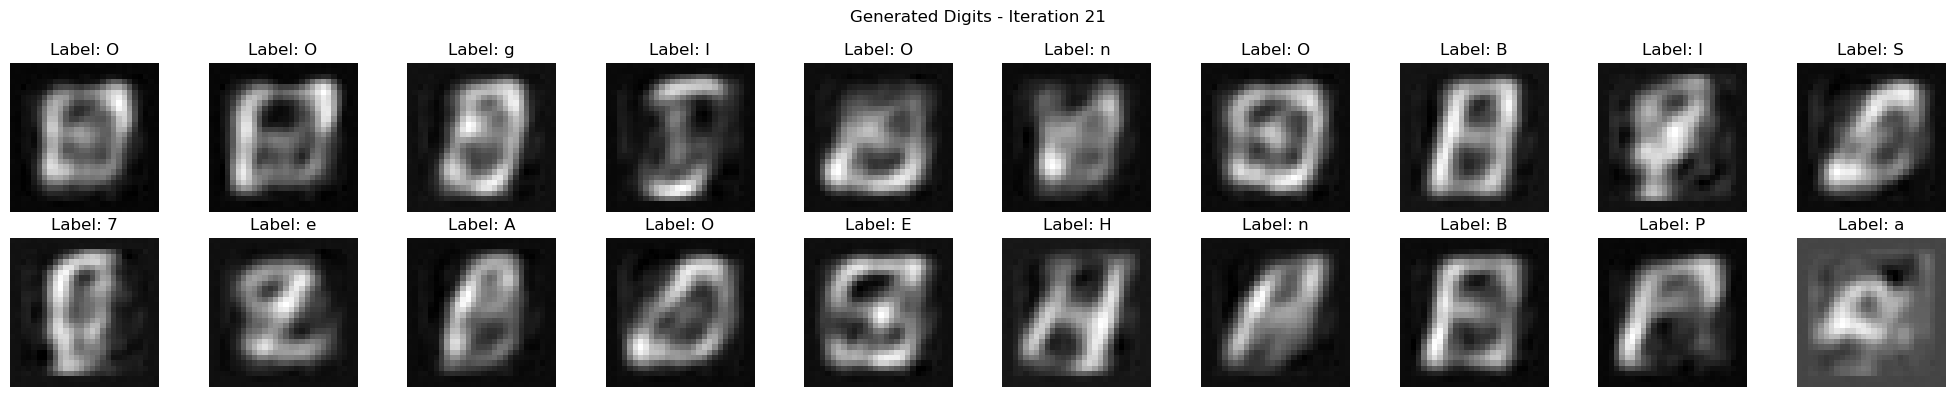

Iteration 22/25
VAE Epoch 10/100, Loss: 22.7066
VAE Epoch 20/100, Loss: 22.7041
VAE Epoch 30/100, Loss: 22.7110
VAE Epoch 40/100, Loss: 22.7003
VAE Epoch 50/100, Loss: 22.7068
VAE Epoch 60/100, Loss: 22.7031
VAE Epoch 70/100, Loss: 22.7062
VAE Epoch 80/100, Loss: 22.7119
VAE Epoch 90/100, Loss: 22.6978
VAE Epoch 100/100, Loss: 22.7066
Classifier Epoch 10/50, Loss: 0.0031, Accuracy: 0.8465
Classifier Epoch 20/50, Loss: 0.0021, Accuracy: 0.8973
Classifier Epoch 30/50, Loss: 0.0014, Accuracy: 0.9300
Classifier Epoch 40/50, Loss: 0.0010, Accuracy: 0.9536
Classifier Epoch 50/50, Loss: 0.0007, Accuracy: 0.9650


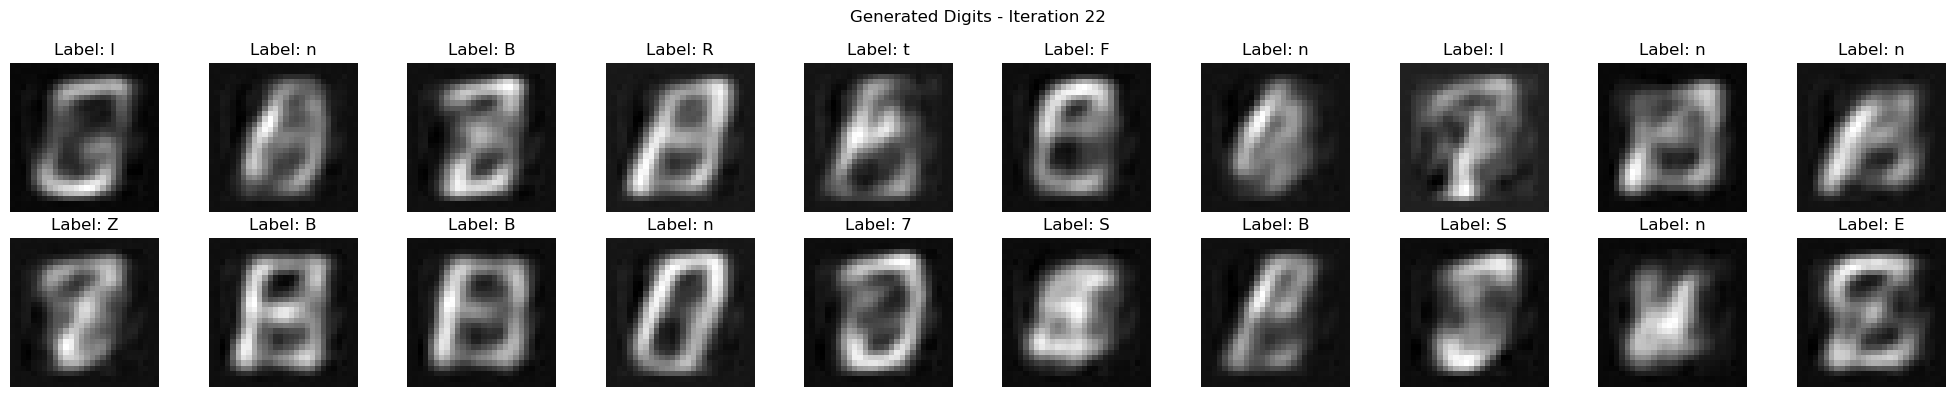

Iteration 23/25
VAE Epoch 10/100, Loss: 20.9895
VAE Epoch 20/100, Loss: 20.9831
VAE Epoch 30/100, Loss: 20.9888
VAE Epoch 40/100, Loss: 20.9703
VAE Epoch 50/100, Loss: 20.9831
VAE Epoch 60/100, Loss: 20.9803
VAE Epoch 70/100, Loss: 20.9647
VAE Epoch 80/100, Loss: 20.9606
VAE Epoch 90/100, Loss: 20.9711
VAE Epoch 100/100, Loss: 20.9674
Classifier Epoch 10/50, Loss: 0.0030, Accuracy: 0.8507
Classifier Epoch 20/50, Loss: 0.0020, Accuracy: 0.8978
Classifier Epoch 30/50, Loss: 0.0015, Accuracy: 0.9273
Classifier Epoch 40/50, Loss: 0.0010, Accuracy: 0.9493
Classifier Epoch 50/50, Loss: 0.0008, Accuracy: 0.9604


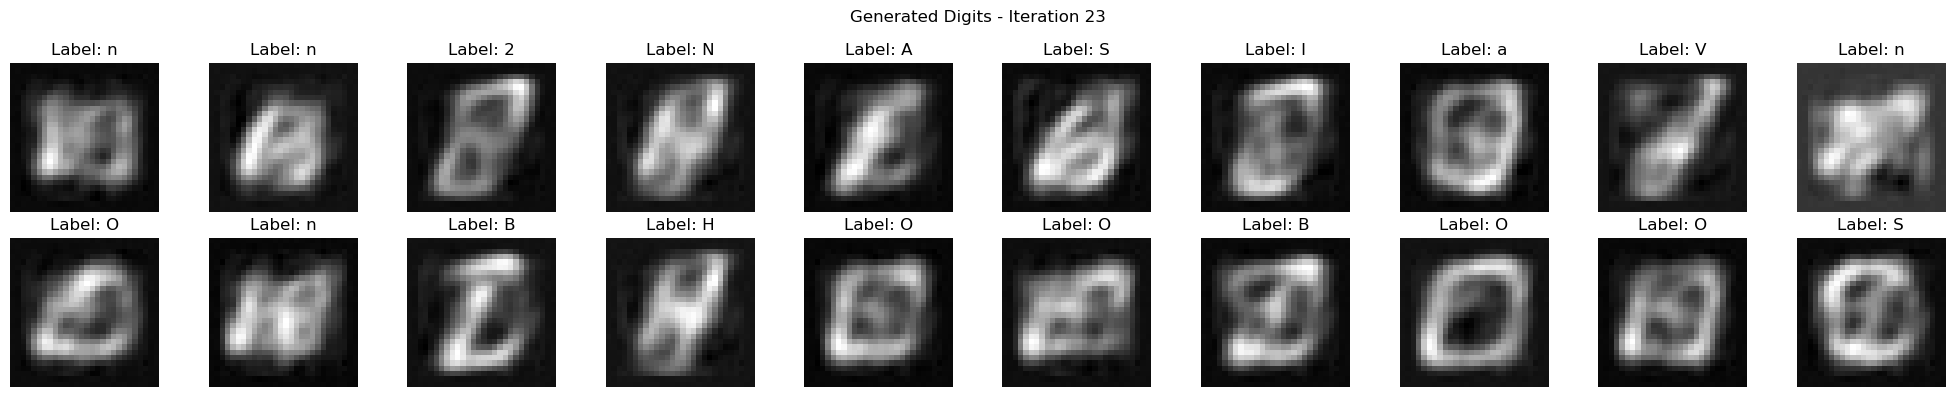

Iteration 24/25
VAE Epoch 10/100, Loss: 19.7475
VAE Epoch 20/100, Loss: 19.7540
VAE Epoch 30/100, Loss: 19.7475
VAE Epoch 40/100, Loss: 19.7448
VAE Epoch 50/100, Loss: 19.7481
VAE Epoch 60/100, Loss: 19.7257
VAE Epoch 70/100, Loss: 19.7430
VAE Epoch 80/100, Loss: 19.7405
VAE Epoch 90/100, Loss: 19.7498
VAE Epoch 100/100, Loss: 19.7328
Classifier Epoch 10/50, Loss: 0.0028, Accuracy: 0.8629
Classifier Epoch 20/50, Loss: 0.0019, Accuracy: 0.9030
Classifier Epoch 30/50, Loss: 0.0014, Accuracy: 0.9319
Classifier Epoch 40/50, Loss: 0.0010, Accuracy: 0.9491
Classifier Epoch 50/50, Loss: 0.0008, Accuracy: 0.9613


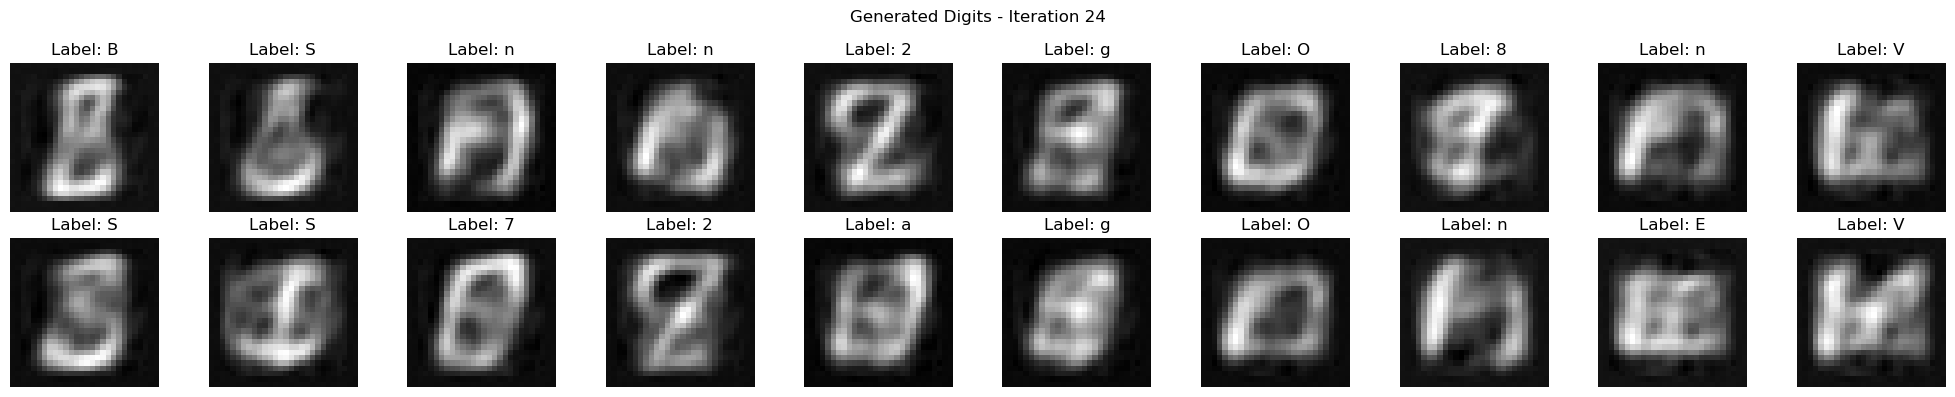

Iteration 25/25
VAE Epoch 10/100, Loss: 19.0501
VAE Epoch 20/100, Loss: 19.0566
VAE Epoch 30/100, Loss: 19.0564
VAE Epoch 40/100, Loss: 19.0456
VAE Epoch 50/100, Loss: 19.0540
VAE Epoch 60/100, Loss: 19.0460
VAE Epoch 70/100, Loss: 19.0510
VAE Epoch 80/100, Loss: 19.0402
VAE Epoch 90/100, Loss: 19.0425
VAE Epoch 100/100, Loss: 19.0327
Classifier Epoch 10/50, Loss: 0.0026, Accuracy: 0.8723
Classifier Epoch 20/50, Loss: 0.0017, Accuracy: 0.9143
Classifier Epoch 30/50, Loss: 0.0012, Accuracy: 0.9395
Classifier Epoch 40/50, Loss: 0.0009, Accuracy: 0.9565
Classifier Epoch 50/50, Loss: 0.0007, Accuracy: 0.9680


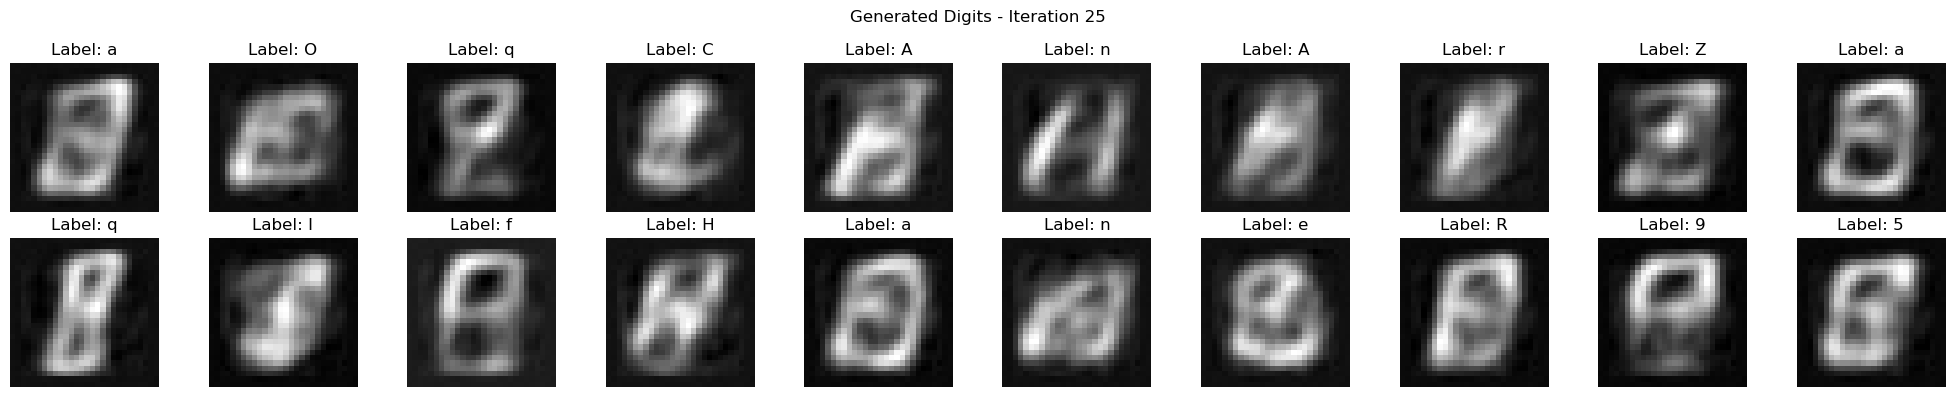

In [7]:
# Alternative CNN code. Not tested.

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn.functional as F # check this
#import torch.nn.functional as F  # Added this import

# CNN hyperparameters
cnn_channels = [32, 64, 128]  # Number of channels in each convolutional layer
cnn_kernel_sizes = [3, 3, 3]  # Kernel sizes for each convolutional layer
cnn_strides = [1, 1, 1]  # Strides for each convolutional layer
cnn_paddings = [1, 1, 1]  # Paddings for each convolutional layer
use_pooling = True  # Whether to use max pooling after each conv layer
pool_size = 2  # Size of the max pooling window
fc_layers = [256, 128]  # Fully connected layers after convolutions

# Define hyperparameters # As of right now, these are broadly speaking the same parameters as used in the MNIST trial
batch_size = 128
latent_dim = 50 # the smallest layer in the VAE. Setting to 30 feels about right, and is slightly larger than MNIST. Attempted with 50?
vae_hidden_layers = [256, 128, 64] # numbers of neurons in fully connected layers
classifier_hidden_dim = 512 # hidden dimension in the classifier
learning_rate = 5e-4 # smaller than before. I had only ever used 1e-3. Hopefully this helps later training.
vae_num_epochs = 100 # higher slows collapse # set to 300 here rather than 200 in the earlier trials. More classes, so may need more space
# set to 2 temporarily so that the classifier can be tested
classifier_num_epochs = 50 # Larger numbers required for EMNIST
# set to 2 temporarily. Try 100?
num_iterations = 25  # Number of times to repeat the process
num_samples = 112800  # Number of samples to generate in each iteration # Note that original EMNIST (all 112800) are still used regardless of this value for the first iteration
num_images = 20 # This is for printing samples. Not actually relevant to the code logic
# the number of samples is presently set to 60000 for comparison with the MNIST work. Will be interesting to see how this winds up working

# Load original EMNIST dataset
dataset_mean = 0.1751
dataset_std = 0.3332
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((dataset_mean,), (dataset_std,)) # mean and variance. See later cells to see how these were calculated
    # normalisation accelerates convergence of the VAE, and possibly of the classifier. However, it means MSE as opposed to BCE must be used
])

original_dataset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform) # separate download each time

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_layers, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(hidden_layers[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_layers[-1], latent_dim)
        
        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_layers):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(hidden_layers[0], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the Classifier
# Classifier loss is given as cross entropy. Defined in the classifier train loop (train_classifier)
class Classifier(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes, 
                 cnn_channels, cnn_kernel_sizes, cnn_strides, cnn_paddings, 
                 use_pooling, pool_size, fc_layers):
        super(Classifier, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.use_pooling = use_pooling
        
        # Convolutional layers
        for i in range(len(cnn_channels)):
            in_channels = input_channels if i == 0 else cnn_channels[i-1]
            self.conv_layers.append(nn.Conv2d(in_channels, cnn_channels[i], 
                                              kernel_size=cnn_kernel_sizes[i], 
                                              stride=cnn_strides[i], 
                                              padding=cnn_paddings[i]))
            if use_pooling:
                self.conv_layers.append(nn.MaxPool2d(pool_size))
        
        # Calculate the size of the feature maps after convolutions and pooling
        def conv_output_size(size, kernel_size, stride, padding):
            return (size - kernel_size + 2 * padding) // stride + 1
        
        for i in range(len(cnn_channels)):
            input_height = conv_output_size(input_height, cnn_kernel_sizes[i], cnn_strides[i], cnn_paddings[i])
            input_width = conv_output_size(input_width, cnn_kernel_sizes[i], cnn_strides[i], cnn_paddings[i])
            if use_pooling:
                input_height //= pool_size
                input_width //= pool_size
        
        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        prev_dim = cnn_channels[-1] * input_height * input_width
        for fc_size in fc_layers:
            self.fc_layers.append(nn.Linear(prev_dim, fc_size))
            prev_dim = fc_size
        self.fc_layers.append(nn.Linear(prev_dim, num_classes))
        
    def forward(self, x):
        # Convolutional layers
        for layer in self.conv_layers:
            x = F.relu(layer(x))
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        for layer in self.fc_layers[:-1]:
            x = F.relu(layer(x))
        
        # Final layer (no activation)
        x = self.fc_layers[-1](x)
        
        return x

# VAE loss function
def vae_loss_function(recon_x, x, mu, logvar): # recon_x is short for reconstructed
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction='sum') # MSE required. BCE can be used if normalisation is not introduced
    # BCE makes more theoretical sense, but seems irrelevant in practice
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # closed form for KLD between gaussians
    return MSE + KLD

# Train VAE
def train_vae(vae, optimizer, dataloader):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data) # reconstructed batch straight from vae.forward
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward() # fails when reparameterisation isn't implemented appropriately
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(dataloader.dataset) # necessary for stability if num_samples is not equal to 60,000

# Update the train_classifier function
def train_classifier(classifier, optimizer, dataloader):
    classifier.train()
    criterion = nn.CrossEntropyLoss()
    train_loss = 0
    correct = 0
    for data, target in dataloader:
        data = data.view(-1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)
        optimizer.zero_grad()
        output = classifier(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    return train_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

# Function to generate new digits. Note that this is for training the next iteration of the models. The visualisation occurs elsewhere, and displays the first num_images of these generated samples
def generate_digits(vae, num_samples):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        samples = vae.decode(z)
    return samples

# This could probably be done by specifying regions in latent space instead. How could I do this?
def classify_digits(classifier, digits, batch_size=batch_size):
    classifier.eval()
    dataset = TensorDataset(digits)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].view(-1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)
            output = classifier(batch)
            labels = output.argmax(dim=1)
            all_labels.append(labels)
    
    return torch.cat(all_labels)


def visualize_digits(digits, labels, iteration): # removed the original EMINST code and replaced it with MNIST work. Should work fine?
    num_digits = len(digits)
    num_rows = math.ceil(num_digits / 10) # required  to allow arbitrary numbers to be shown
    # Currently creates a single image out of all of them with 10 columns, and the digits stacked on top of one another
    num_cols = min(num_digits, 10)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2*num_rows))
    fig.suptitle(f'Generated Digits - Iteration {iteration}')

    balanced_dict = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 
                 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 
                 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}

    if num_rows == 1:
        axes = axes.reshape(1, -1) # avoid index errors

    for i in range(num_digits):
        row = i // 10
        col = i % 10
        ax = axes[row, col]
        image = digits[i].reshape(28, 28)
        rotated_image = torch.rot90(image, k=-1)
        flipped_image = torch.flip(rotated_image, dims=[1])
        ax.imshow(flipped_image.squeeze(), cmap='gray') # recreates original MNIST images as faithfully as possible. Perhaps a custom cmap would be better for historic accuracy?
        ax.set_title(f'Label: {balanced_dict[labels[i].item()]}') # NOTE: Printed images are not sorted by label in any way. This could be resolved in future?
        ax.axis('off')

    # Remove any unused subplots. Without this, there may be graphical glitches and poorly placed images
    for i in range(num_digits, num_rows * num_cols):
        row = i // 10
        col = i % 10
        fig.delaxes(axes[row, col])

    plt.tight_layout() # I might want this. It seems to place the title too low, such that it overlaps with the images themselves. Removing this fixes the title issue
    plt.show()

# Update the evaluate_classifier function
def evaluate_classifier(classifier, dataloader):
    classifier.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            data = data.view(-1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)
            output = classifier(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Main loop. Iterates over training of models and generating samples for new models
current_dataset = original_dataset
classifiers = []
loss_matrix = np.zeros((num_iterations, num_iterations)) # numpy shortcut for square zeros?
accuracy_matrix = np.zeros((num_iterations, num_iterations))

vae = VAE(784, vae_hidden_layers, latent_dim) # VAE is not reset after each iteration to save on computational time, requiring fewer generations to keep sensible results
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    # Create DataLoader
    dataloader = DataLoader(current_dataset, batch_size=batch_size, shuffle=True)

    # Initialize and train VAE
    #vae = VAE(784, vae_hidden_dim, latent_dim) 
    # currently not being reinitialised. Defining externally makes training more efficient, and more like model collapse
    vae_optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    for epoch in range(vae_num_epochs):
        loss = train_vae(vae, vae_optimizer, dataloader)
        if (epoch + 1) % 10 == 0:
            print(f'VAE Epoch {epoch+1}/{vae_num_epochs}, Loss: {loss:.4f}')

    # Update the classifier initialization in the main loop
    # Note that this no longer has 784 input size as it has to be set explicitly into a 2D array
    classifier = Classifier(input_channels=1, input_height=28, input_width=28, num_classes=47,
                        cnn_channels=cnn_channels, cnn_kernel_sizes=cnn_kernel_sizes,
                        cnn_strides=cnn_strides, cnn_paddings=cnn_paddings,
                        use_pooling=use_pooling, pool_size=pool_size, fc_layers=fc_layers)
    
    classifier_optimizer = optim.Adam(classifier.parameters(), lr=learning_rate) # does this need to be respecified?
    for epoch in range(classifier_num_epochs):
        loss, accuracy = train_classifier(classifier, classifier_optimizer, dataloader)
        if (epoch + 1) % 10 == 0:
            print(f'Classifier Epoch {epoch+1}/{classifier_num_epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    # Store the trained classifier in classifiers list. Used later for overall evaluation
    classifiers.append(classifier)

    # Generate new dataset
    generated_digits = generate_digits(vae, num_samples)
    generated_labels = classify_digits(classifier, generated_digits) # from prev classifier notably

    # Visualize some generated digits
    #visualize_digits(generated_digits[:num_images*num_cols], generated_labels[:num_images*num_cols], iteration + 1, num_rows=num_images, num_cols=num_cols) # num_images used to be set to 25. Produces no issues
    visualize_digits(generated_digits[:num_images], generated_labels[:num_images], iteration + 1) # num_images used to be set to 25. Produces no issues


    # Create new dataset for next iteration
    current_dataset = TensorDataset(generated_digits, generated_labels) # torch.utils.data.TensorDataset

    # Evaluate all previous classifiers on the new dataset, and writing to the loss and accuracy arrays
    new_dataloader = DataLoader(current_dataset, batch_size=batch_size, shuffle=False) # shuffle should be unnecessary as the sampling from the latent space is random
    for prev_iteration, prev_classifier in enumerate(classifiers):
        loss, accuracy = evaluate_classifier(prev_classifier, new_dataloader)
        loss_matrix[prev_iteration, iteration] = loss
        accuracy_matrix[prev_iteration, iteration] = accuracy

    # This line can be used to save the current dataset for later analysis. Requires drive loading
    #torch.save(current_dataset, f'generated_dataset_iteration_{iteration + 1}.pt')

# Save matrices for further analysis
#np.save('loss_matrix_EMNIST.npy', loss_matrix)
#np.save('accuracy_matrix_EMNIST.npy', accuracy_matrix)

# If this is broken, it is probably the classifer. Sorry.

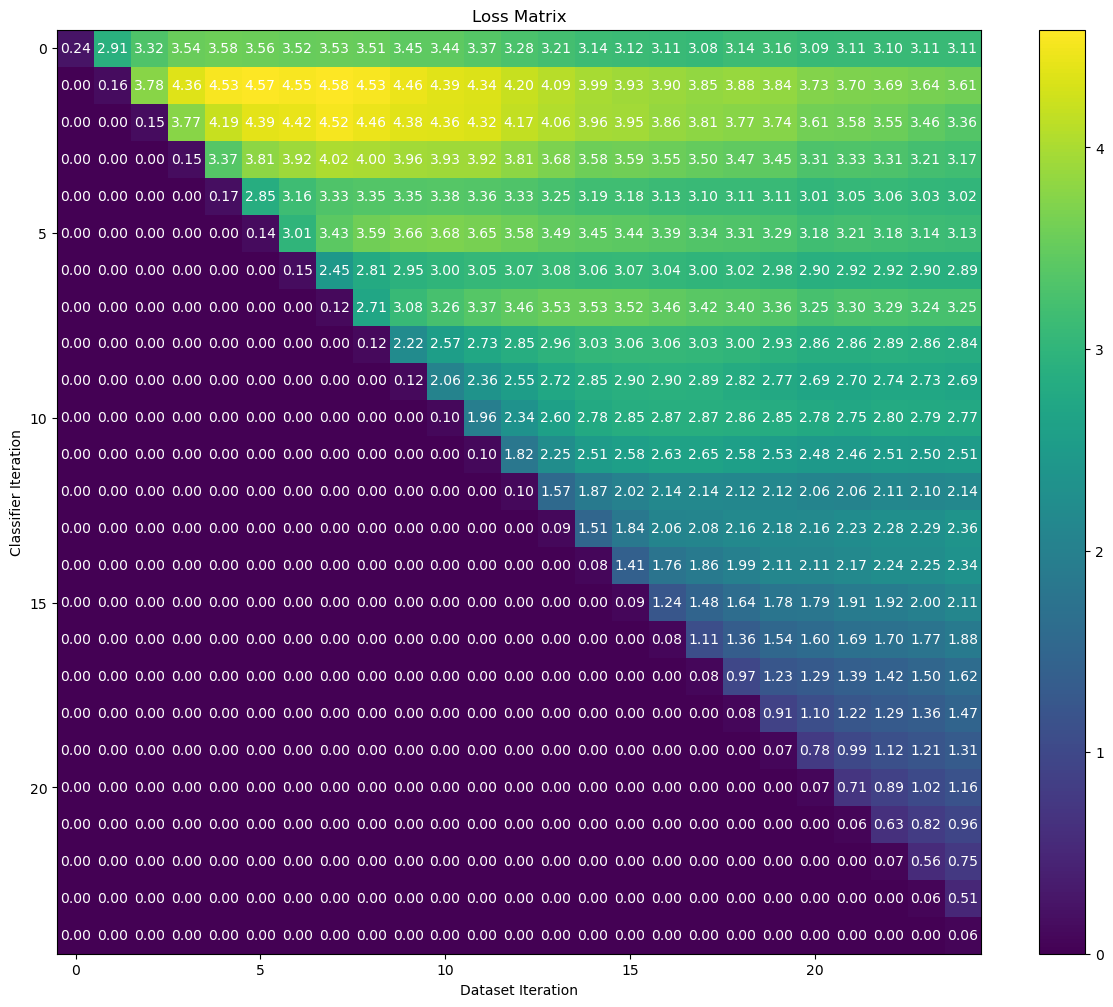

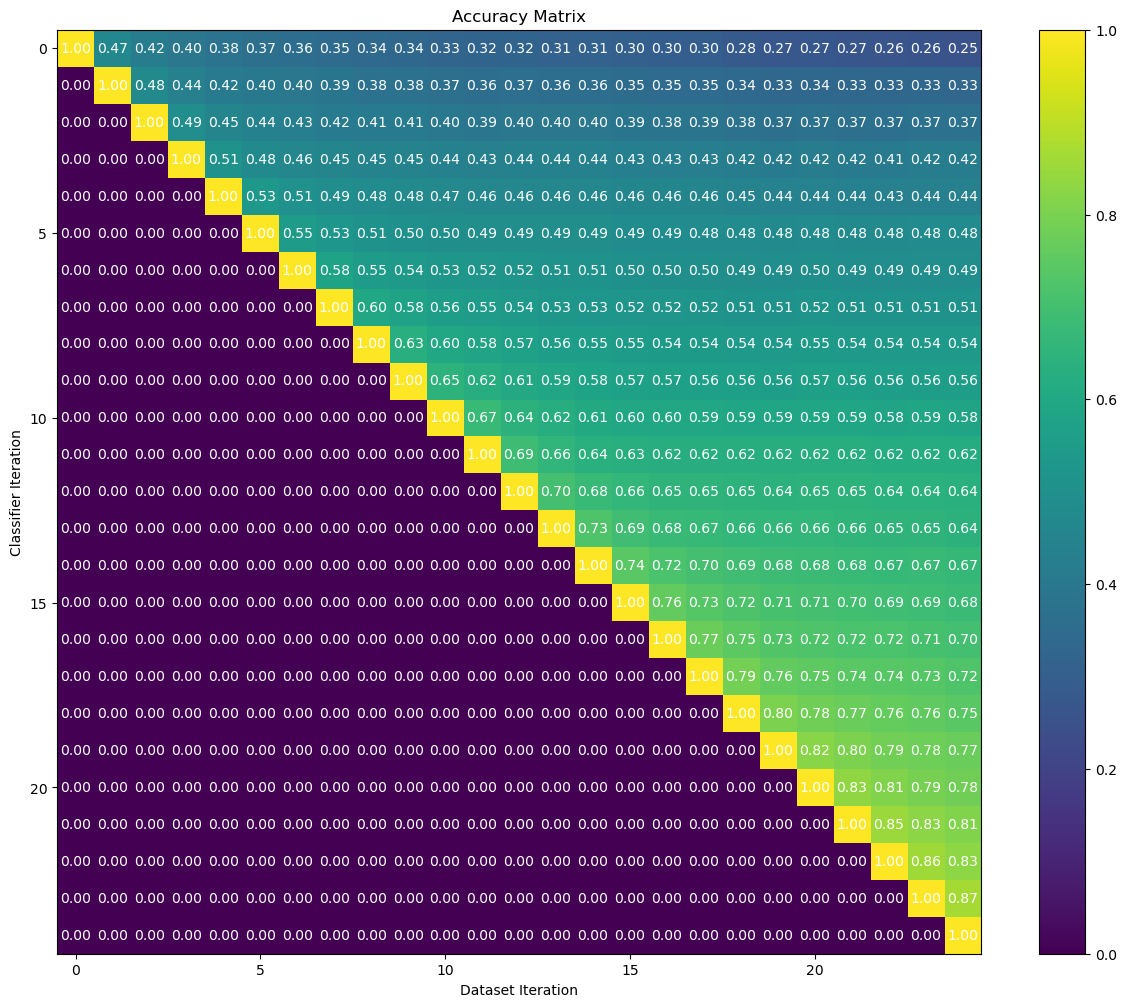

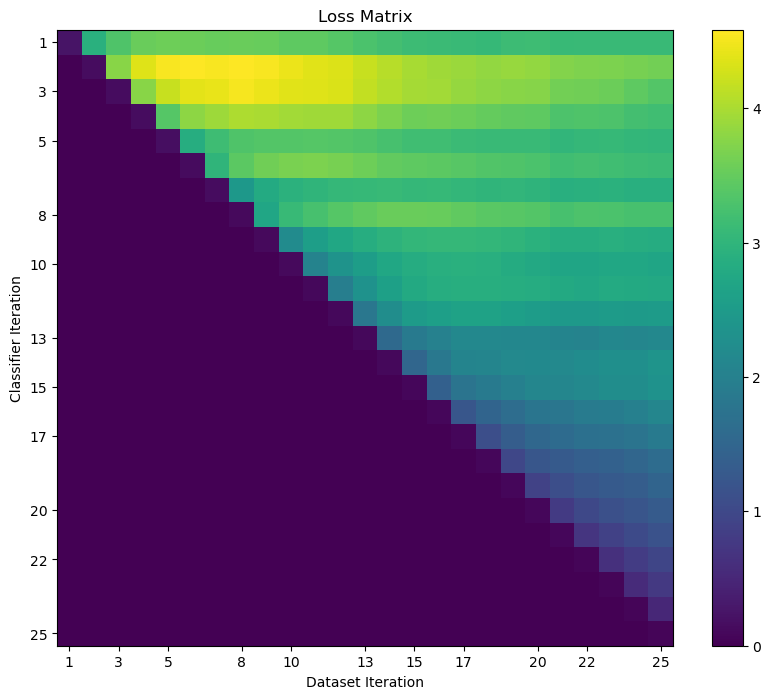

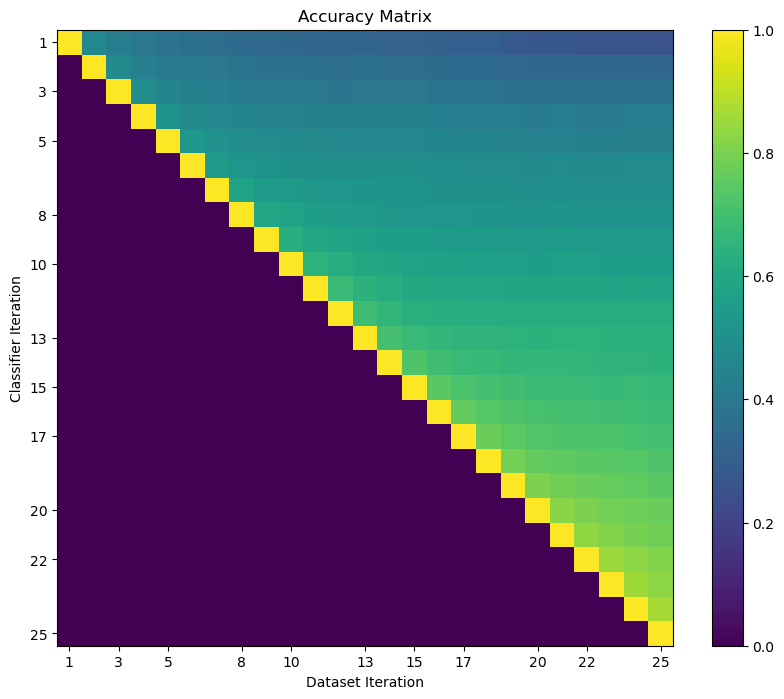

In [8]:
# In this cell, loss and accuracy are displayed

# Visualize the loss and accuracy matrices
def plot_matrix(matrix, title, cmap='viridis'): # I have decided I have viridis
    plt.figure(figsize=(15, 12)) # made larger than previous versions. To help with readability of text
    plt.imshow(matrix, cmap=cmap)
    plt.colorbar() # considerably better visualisation
    plt.title(title)
    plt.xlabel('Dataset Iteration')
    plt.ylabel('Classifier Iteration')
    for i in range(matrix.shape[0]): # NOTE: Currently counts from 0. I should probably shift it to counting from 1, like all humans do
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white')
    #plt.tight_layout() # produces graphical bugs with the title, but is clearer with the colourbar and labels
    plt.show()

# Visualise the loss and accuracy matrices without text. Just colour plots
def colour_plot_matrix(matrix, title, cmap='viridis', num_ticks=11):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Dataset Iteration')
    plt.ylabel('Classifier Iteration')
    
    # Create evenly spaced tick locations
    x_ticks = np.linspace(0, matrix.shape[1] - 1, num_ticks, dtype=int)
    y_ticks = np.linspace(0, matrix.shape[0] - 1, num_ticks, dtype=int)
    
    # Set tick locations and labels
    plt.xticks(x_ticks, x_ticks + 1)  # +1 to start from 1 instead of 0
    plt.yticks(y_ticks, y_ticks + 1)
    
    plt.show()

plot_matrix(loss_matrix, 'Loss Matrix')
plot_matrix(accuracy_matrix, 'Accuracy Matrix')

colour_plot_matrix(loss_matrix, 'Loss Matrix')
colour_plot_matrix(accuracy_matrix, 'Accuracy Matrix')